# Insurance Claims Project

## Set Up

In [5]:
import pandas as pd
df = pd.read_csv("../data/raw/insurance_claims.csv")
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [ ]:
# Import necessary libraries
import numpy as np
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
#from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
import time

#Data Preprocessing


In [ ]:
# remove column _c39 as it contains only null values
df = df.drop(['_c39'], axis = 1)

In [ ]:
# Replace ? with NaN
df = df.replace('?', np.nan)

# Separate columns into Quantitative and Categorical
quantitative_cols = df.select_dtypes(include='number').columns
print("Quantitative Columns:\n", quantitative_cols)

categorical_cols = df.select_dtypes(include='object').columns
print("\nCategorical Columns:\n", categorical_cols)

Quantitative Columns:
 Index(['months_as_customer', 'age', 'policy_number', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip',
       'capital-gains', 'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_year'],
      dtype='object')

Categorical Columns:
 Index(['policy_bind_date', 'policy_state', 'policy_csl', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'incident_date', 'incident_type',
       'collision_type', 'incident_severity', 'authorities_contacted',
       'incident_state', 'incident_city', 'incident_location',
       'property_damage', 'police_report_available', 'auto_make', 'auto_model',
       'fraud_reported'],
      dtype='object')


In [ ]:
# Print unique values for categorical columns
for column in categorical_cols:
  if column == 'policy_bind_date': # skip policy bind date, not important to know the unique values
    continue
  else:
    unique_values = df[column].unique()
    print(f"Unique '{column}': {unique_values}")
print('-'*100)
# Print min max for quantitative columns
for column in quantitative_cols:
    max_values = df[column].max()
    min_values = df[column].min()
    print(f"Column '{column}': Min = {min_values}, Max = {max_values}")

Unique 'policy_state': ['OH' 'IN' 'IL']
Unique 'policy_csl': ['250/500' '100/300' '500/1000']
Unique 'insured_sex': ['MALE' 'FEMALE']
Unique 'insured_education_level': ['MD' 'PhD' 'Associate' 'Masters' 'High School' 'College' 'JD']
Unique 'insured_occupation': ['craft-repair' 'machine-op-inspct' 'sales' 'armed-forces' 'tech-support'
 'prof-specialty' 'other-service' 'priv-house-serv' 'exec-managerial'
 'protective-serv' 'transport-moving' 'handlers-cleaners' 'adm-clerical'
 'farming-fishing']
Unique 'insured_hobbies': ['sleeping' 'reading' 'board-games' 'bungie-jumping' 'base-jumping' 'golf'
 'camping' 'dancing' 'skydiving' 'movies' 'hiking' 'yachting' 'paintball'
 'chess' 'kayaking' 'polo' 'basketball' 'video-games' 'cross-fit'
 'exercise']
Unique 'insured_relationship': ['husband' 'other-relative' 'own-child' 'unmarried' 'wife' 'not-in-family']
Unique 'incident_date': ['2015-01-25' '2015-01-21' '2015-02-22' '2015-01-10' '2015-02-17'
 '2015-01-02' '2015-01-13' '2015-02-27' '2015-01-30

In [ ]:
# To make policy_bind_date & incident_date more meaningful, we will take the difference between the 2 dates
df["incident_minus_policy_bind_date"] = (pd.to_datetime(df["incident_date"])-pd.to_datetime(df["policy_bind_date"])).dt.days

In [ ]:
print(df.isnull().sum())

months_as_customer                   0
age                                  0
policy_number                        0
policy_bind_date                     0
policy_state                         0
policy_csl                           0
policy_deductable                    0
policy_annual_premium                0
umbrella_limit                       0
insured_zip                          0
insured_sex                          0
insured_education_level              0
insured_occupation                   0
insured_hobbies                      0
insured_relationship                 0
capital-gains                        0
capital-loss                         0
incident_date                        0
incident_type                        0
collision_type                     178
incident_severity                    0
authorities_contacted               91
incident_state                       0
incident_city                        0
incident_location                    0
incident_hour_of_the_day 

In [ ]:
# Imputate NaN values

fill_values = {
    'collision_type': df['collision_type'].mode()[0],  # Mode for collision_type
    'property_damage': 'NO',  # Fill 'NO' for property_damage
    'police_report_available': 'NO',  # Fill 'NO' for police_report_available
    'authorities_contacted': 'Other'  # Fill 'others' for authorities_contacted
}

# Apply the fillna operation for all columns in the dictionary
df.fillna(value=fill_values, inplace=True)

# Verify the changes
print(df.isna().sum())

months_as_customer             0
age                            0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_rep

fraud_reported
N    753
Y    247
Name: count, dtype: int64


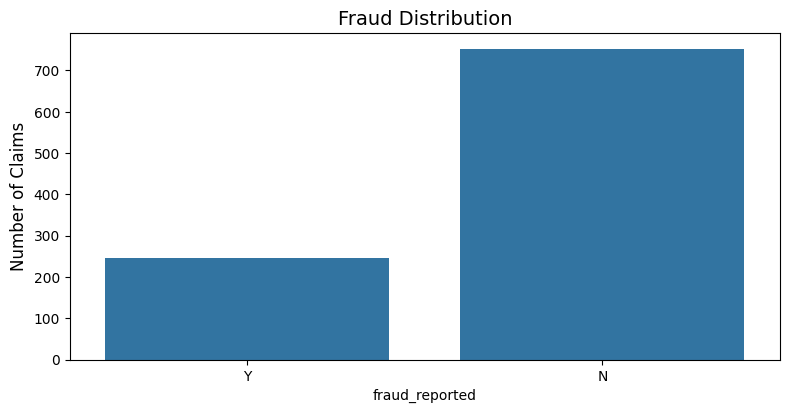

In [ ]:
# To visualize distribution of fraud/non-fraud claims
print(df['fraud_reported'].value_counts())

plt.figure(figsize=(8, 4))
sns.countplot(x='fraud_reported', data=df)
plt.ylabel('Number of Claims', fontsize=12)
plt.tight_layout()
plt.title("Fraud Distribution", fontsize=14)
plt.savefig("fraud_distribution.png")
plt.show()

The visualization above suggests that the dataset is quite imbalanced, therefore it may require sampling methods like SMOTE.

**Age Analysis**

In [ ]:
df['age'].describe()

,age
count,1000.000000
mean,38.948000
std,9.140287
min,19.000000
25%,32.000000
50%,38.000000
75%,44.000000
max,64.000000


In [ ]:
# Segment age into different age groups to better discover patterns

bins = list(range(15,66,5))

labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65']

df['age_range'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df['age_range'] = df['age_range'].astype(str)



fraud_counts = df.groupby('age_range')['fraud_reported'].value_counts().unstack().fillna(0)
fraud_counts.columns = ['Non-Fraud', 'Fraud']
fraud_counts = fraud_counts.reset_index()

print(fraud_counts)

  age_range  Non-Fraud  Fraud
0     15-20        0.0    1.0
1     21-25       18.0    7.0
2     26-30       97.0   32.0
3     31-35      149.0   56.0
4     36-40      155.0   40.0
5     41-45      148.0   48.0
6     46-50       97.0   25.0
7     51-55       36.0   13.0
8     56-60       35.0   16.0
9     61-65       18.0    9.0


<Figure size 800x400 with 0 Axes>

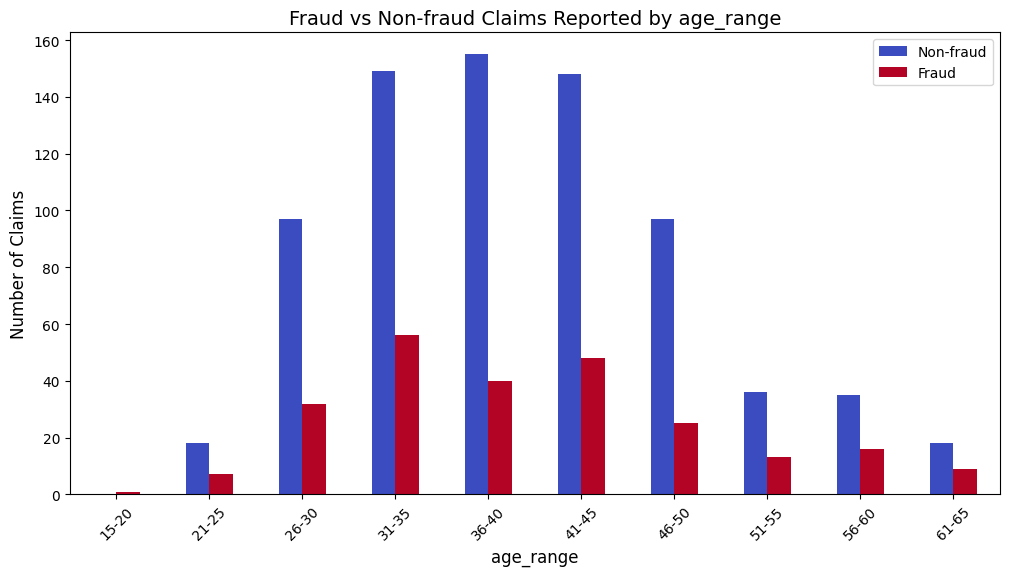

In [ ]:
def plot_fraud_cases(fraud_counts, category_col, original_col, category_order, bins):
    """
    Function to plot fraud cases by a specified categorical column.

    Parameters:
    fraud_counts (pd.DataFrame): DataFrame containing fraud data with the specified categorical column and counts.
    category_col (str): The name of the categorical column to group by (e.g., 'age_range', 'months_as_customer_range').
    category_order (list): Ordered list of categories for sorting.
    """
    df[category_col] = pd.cut(df[original_col], bins=bins, labels=category_order, right=False)
    df[category_col] = df[category_col].astype(str)

    fraud_counts = df.groupby(category_col)['fraud_reported'].value_counts().unstack().fillna(0)
    fraud_counts.columns = ['Non-Fraud', 'Fraud']
    fraud_counts = fraud_counts.reset_index()
    # Ensure the specified column is categorical and ordered
    fraud_counts[category_col] = pd.Categorical(fraud_counts[category_col], categories=category_order, ordered=True)
    fraud_counts = fraud_counts.sort_values(category_col)

    # Plot
    plt.figure(figsize=(8, 4))
    fraud_counts.set_index(category_col).plot(kind='bar', stacked=False, figsize=(12, 6), colormap='coolwarm')

    plt.xlabel(category_col, fontsize=12)
    plt.ylabel('Number of Claims', fontsize=12)
    plt.title(f'Fraud vs Non-fraud Claims Reported by {category_col}', fontsize=14)
    plt.legend(['Non-fraud', 'Fraud'])
    plt.xticks(rotation=45)
    plt.savefig("fraud_vs_non_fraud_claims_by_age_range")
    plt.show()

plot_fraud_cases(df, 'age_range','age', labels, list(range(15,66,5)))

We can see that people in the age range from 31-45 has a higher count of  frauds as compared to other age range. Therefore, we will proceed to section the age variable to 15-25 (young adults), 26-45 (middle aged adults) and 46-65 (older adults).

In [ ]:
df['age_range'] = df['age'].apply(lambda age: 'young adults' if 15 <= age <= 25 else 'middle aged adults' if 26 <= age <= 45 else 'older adults')

In [ ]:
df['age_range'].head()

,age_range
0,older adults
1,middle aged adults
2,middle aged adults
3,middle aged adults
4,middle aged adults


<Figure size 800x400 with 0 Axes>

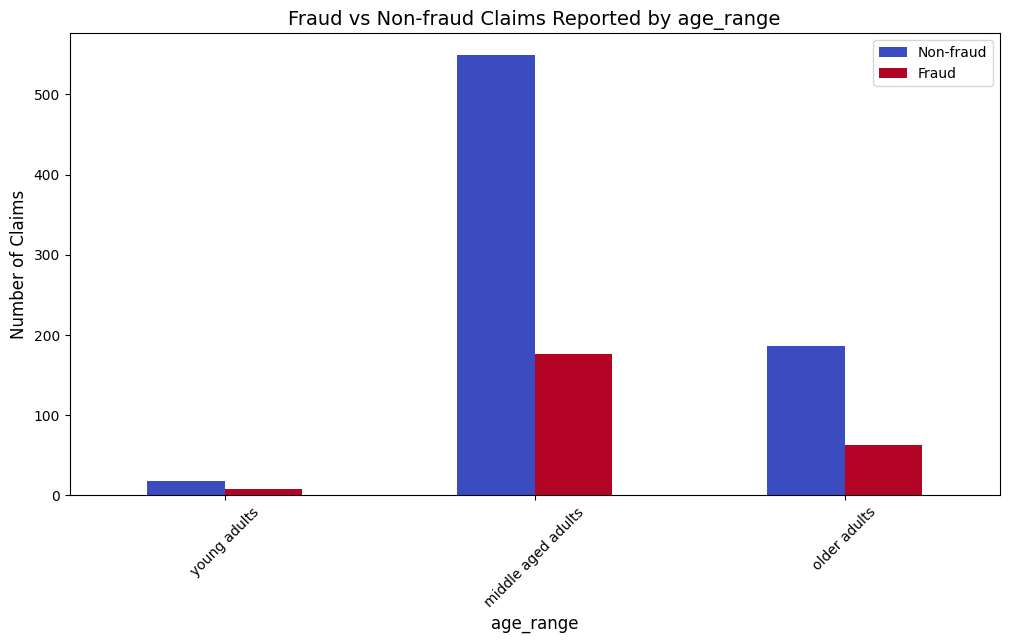

In [ ]:
age_order = ['young adults', 'middle aged adults', 'older adults']
plot_fraud_cases(df, 'age_range','age', age_order, [15, 25, 45, 65])

In [ ]:
df['months_as_customer'].describe()

,months_as_customer
count,1000.000000
mean,203.954000
std,115.113174
min,0.000000
25%,115.750000
50%,199.500000
75%,276.250000
max,479.000000


In [ ]:
bins = list(range(0, 481,60))

labels = ['0-60', '61-120', '121-180', '181-240', '241-300', '301-360', '361-420', '421-480']

df['months_as_customer_range'] = pd.cut(df['months_as_customer'], bins=bins, labels=labels, right=False)
df['months_as_customer_range'] = df['months_as_customer_range'].astype(str)
df['months_as_customer_range'] = pd.Categorical(df['months_as_customer_range'], categories=labels, ordered=True)


fraud_counts = df.groupby('months_as_customer_range')['fraud_reported'].value_counts().unstack().fillna(0)
fraud_counts.columns = ['Non-Fraud', 'Fraud']
fraud_counts = fraud_counts.reset_index()

print(fraud_counts)

  months_as_customer_range  Non-Fraud  Fraud
0                     0-60         76     25
1                   61-120        117     41
2                  121-180        143     45
3                  181-240        133     41
4                  241-300        163     45
5                  301-360         44     16
6                  361-420         34     17
7                  421-480         43     17


<ipython-input-48-9964ce75caf4>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_counts = df.groupby('months_as_customer_range')['fraud_reported'].value_counts().unstack().fillna(0)


<Figure size 800x400 with 0 Axes>

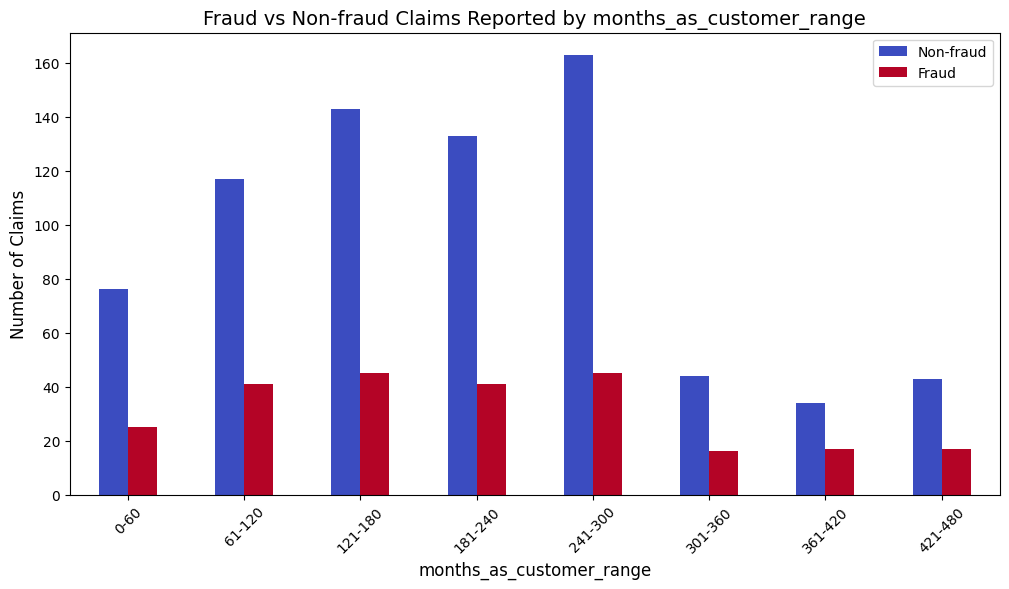

In [ ]:
# Segment months_as_customer into different groups to better discover patterns
bins = list(range(0, 481,60))

labels = ['0-60', '61-120', '121-180', '181-240', '241-300', '301-360', '361-420', '421-480']

plot_fraud_cases(df, 'months_as_customer_range' ,'months_as_customer', labels, bins)

We can see that fraud claims are more prevalant when months_as_customer < 300, therefore we will proceed to group them as 0-60 months (short term), 61-300 (mid term), 301-480 (long term).

In [ ]:
df['months_as_customer_range'] = df['months_as_customer'].apply(lambda months: 'short term' if 0 <= months <= 60 else 'mid term' if 61 <= months <= 300 else 'long term')

<Figure size 800x400 with 0 Axes>

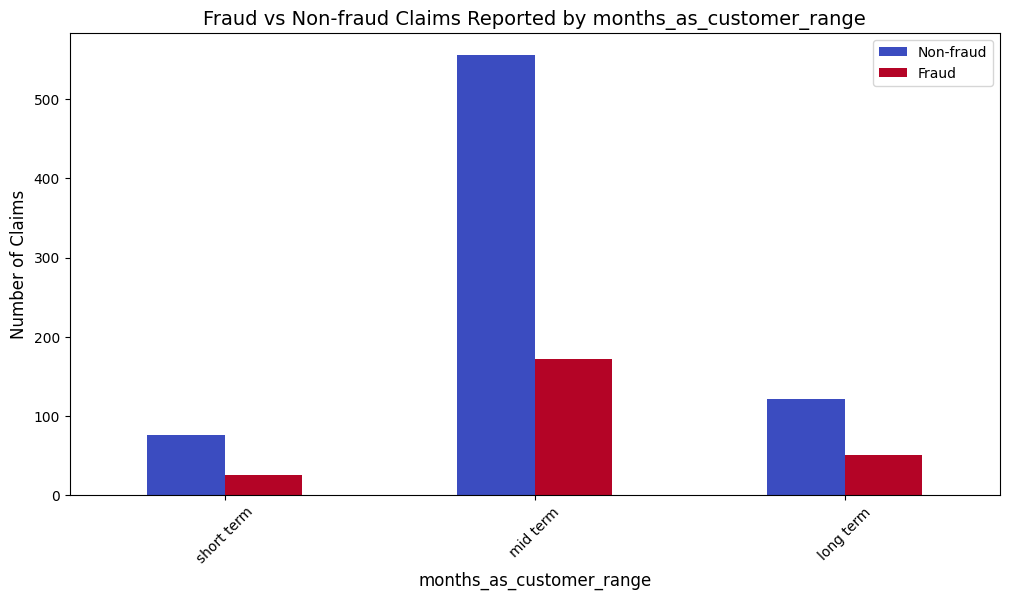

In [ ]:
order = ['short term', 'mid term', 'long term']
plot_fraud_cases(df, 'months_as_customer_range','months_as_customer', order, [0, 60, 300, 480])

<Figure size 800x400 with 0 Axes>

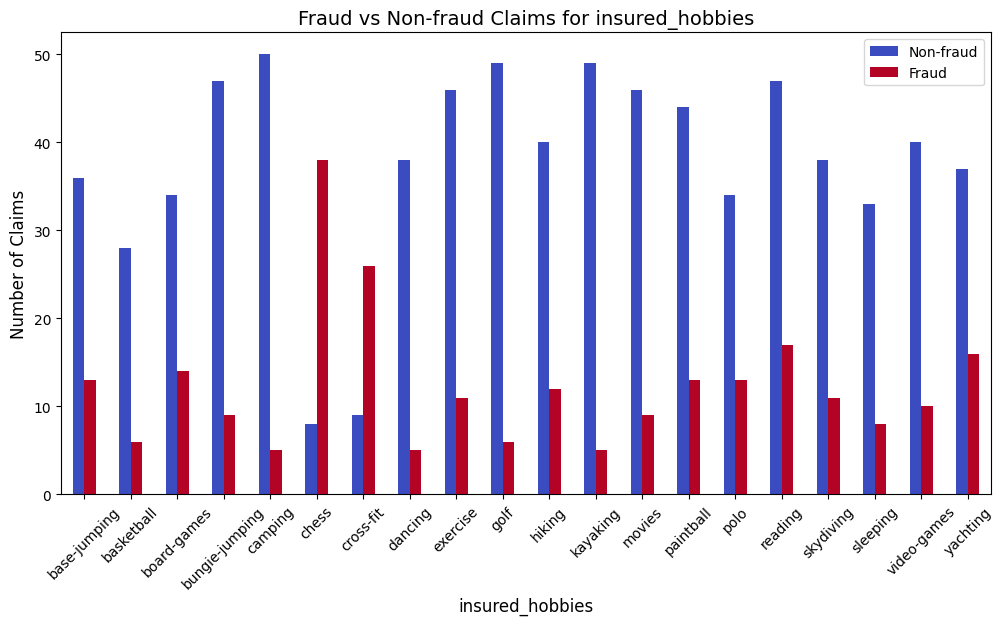

In [ ]:
# to plot fraud/non-fraud according to insured_hobbies
fraud_hobbies = df.groupby('insured_hobbies')['fraud_reported'].value_counts().unstack().fillna(0)
fraud_hobbies.columns = ['Non-Fraud', 'Fraud']
fraud_hobbies = fraud_hobbies.reset_index()

plt.figure(figsize=(8, 4))
fraud_hobbies.set_index('insured_hobbies').plot(kind='bar', stacked=False, figsize=(12,6), colormap='coolwarm')

plt.xlabel('insured_hobbies', fontsize=12)
plt.ylabel('Number of Claims', fontsize=12)
plt.title('Fraud vs Non-fraud Claims for insured_hobbies', fontsize=14)
plt.legend(['Non-fraud','Fraud'])
plt.xticks(rotation=45)
plt.savefig("fraud_vs_non_fraud_claims_by_insured_hobbies")
plt.show()


An interesting insight is people that has chess as insured hobbies and cross-fit has significantly higher number of fraud reported compared to the rest.

To reduce redundancy, we will only keep cross-fit and chess and rename the other hobbies as 'others'.

In [ ]:
df['insured_hobbies'] = df['insured_hobbies'].apply(lambda x: x if x == 'chess' or x == 'cross-fit' else 'others')

<Figure size 800x400 with 0 Axes>

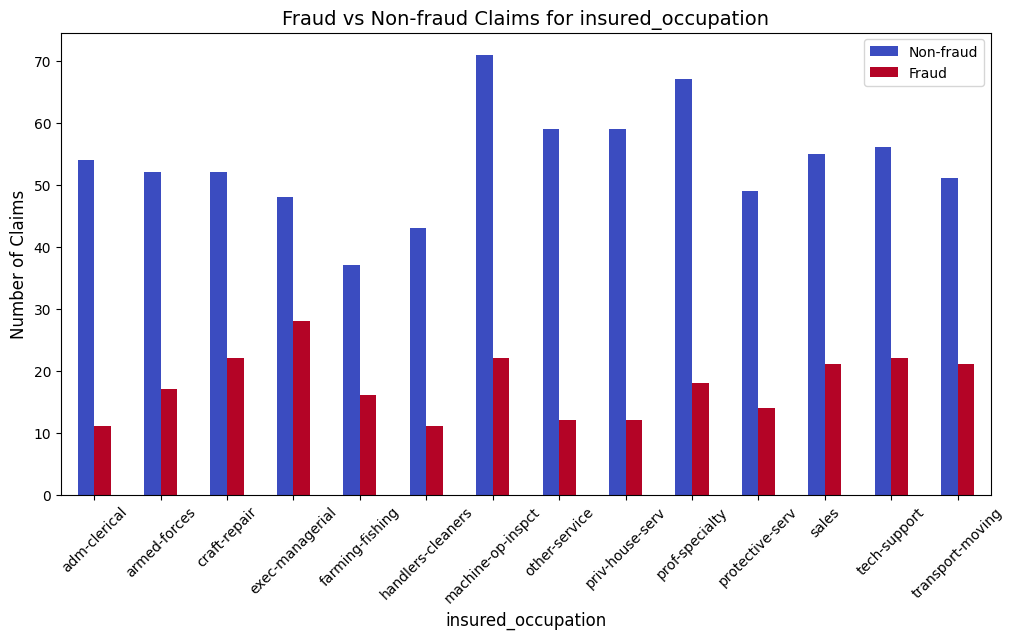

In [ ]:
# to plot fruad/non-fraud according to insured_occupations
fraud_occupations = df.groupby('insured_occupation')['fraud_reported'].value_counts().unstack().fillna(0)
fraud_occupations.columns = ['Non-Fraud', 'Fraud']
fraud_occupations = fraud_occupations.reset_index()

plt.figure(figsize=(8, 4))
fraud_occupations.set_index('insured_occupation').plot(kind='bar', stacked=False, figsize=(12,6), colormap='coolwarm')

plt.xlabel('insured_occupation', fontsize=12)
plt.ylabel('Number of Claims', fontsize=12)
plt.title('Fraud vs Non-fraud Claims for insured_occupation', fontsize=14)
plt.legend(['Non-fraud','Fraud'])
plt.xticks(rotation=45)
plt.savefig("fraud_vs_non_fraud_claims_by_insured_occupation")
plt.show()

People in exec-managerial has more frauds committed than other occupations.

In [ ]:
# Get lon lat of states
geolocator = Nominatim(user_agent="geoapi", timeout=200)
states =  df['incident_state'].unique()  # state names
locations = {}

for state in states:
    location = geolocator.geocode(state + ", USA")
    if location:
        locations[state] = (location.latitude, location.longitude)
    time.sleep(1)

print(locations)

{'SC': (33.6874388, -80.4363743), 'VA': (37.1232245, -78.4927721), 'NY': (43.1561681, -75.8449946), 'OH': (40.2253569, -82.6881395), 'WV': (38.4758406, -80.8408415), 'NC': (35.6729639, -79.0392919), 'PA': (40.9699889, -77.7278831)}


In [ ]:
!pip install -U kaleido
import plotly.express as px

state_counts = df["incident_state"].value_counts().reset_index()
state_counts.columns = ["state", "count"]

state_data = {
    "state": df['incident_state'].unique(),
    "value": locations.values(),  # lat, lon
}

fig = px.choropleth(state_counts,locations='state',
                     locationmode="USA-states",
                     color='count',
                     scope="usa",
                     color_continuous_scale="Reds",
                     title="State-wise Incident Count")

# Update layout to set figure size
fig.update_layout(
    width=800,
    height=600,
)

fig.show()

  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl.metadata (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.3 MB/s eta 0:00:00


Hovering over the visualisation, we can see that the state with the highest incident count is NY (New York) followed by SC (South Carolina).


In [ ]:
# count the fraud cases at each state instead
fraud_cases = df[df['fraud_reported'] == 'Y']
fraud_cases['incident_state'].value_counts()

state_counts = fraud_cases['incident_state'].value_counts().reset_index()
state_counts.columns = ["state", "count"]

state_data = {
    "state": df['incident_state'].unique(),
    "value": locations.values(),  # lat, lon
}

fig = px.choropleth(state_counts,locations='state',
                     locationmode="USA-states",
                     color='count',
                     scope="usa",
                     color_continuous_scale="Reds",
                     title="State-wise Fraud Cases Count")

# Update layout to set figure size
fig.update_layout(
    width=800,
    height=600,
)

fig.show()

From this choropleth map, we can see that SC has the highest fraud count instead followed by NY even though SC has slightly lower incident count compared to NY.

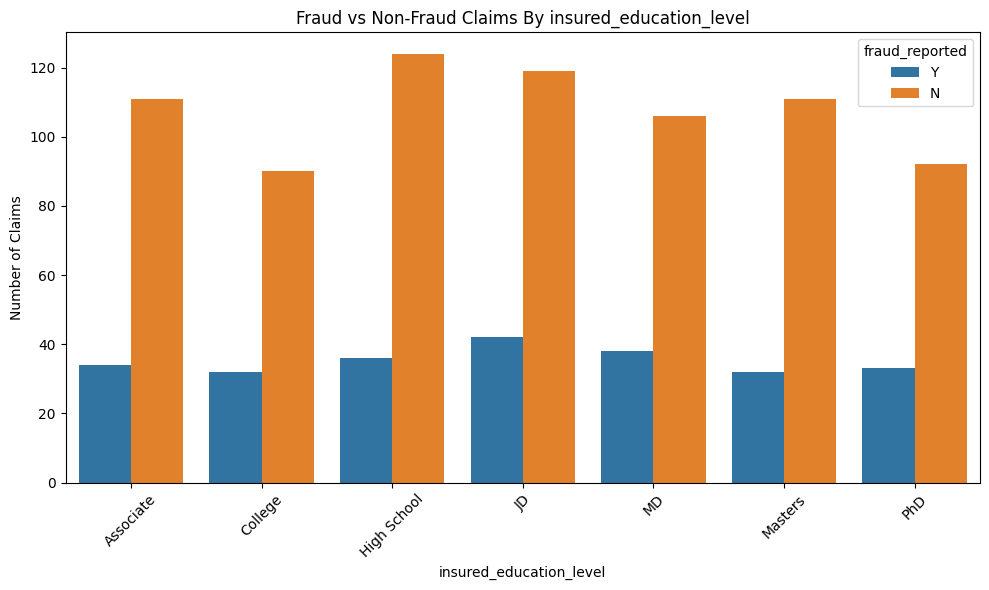

In [ ]:
def fraud_vs_nonfraud_plot(df, x_col, y_col):
    plt.figure(figsize=(10, 6))

    # Count of records for each x/y combination
    sns.countplot(data=df, x=x_col, hue=y_col,order=sorted(df[x_col].unique()))

    plt.title(f'Fraud vs Non-Fraud Claims By {x_col}')
    plt.xlabel(x_col)
    plt.ylabel('Number of Claims')
    plt.legend(title=y_col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("fraud_vs_nonfraud_claims_by_education_level")
    plt.show()
fraud_vs_nonfraud_plot(df, 'insured_education_level', 'fraud_reported')

From the chart above, we can see that the number of fraud/non-fraud claims are quite well distributed among the different insured education level.

In [ ]:
df.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported',
       'incident_minus_policy_bind_date', 'age_range',
       'months_as_customer_range'],
      dtype='object')

<ipython-input-44-a29d200b6ae3>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




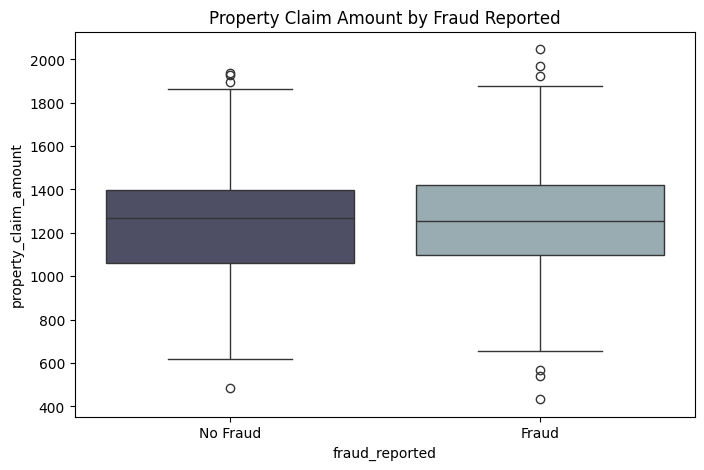

In [ ]:
plt.rcParams['figure.figsize'] = (8, 5)

sns.boxplot(x=df['fraud_reported'], y=df['policy_annual_premium'], palette='bone')

plt.title('Property Claim Amount by Fraud Reported')
plt.xlabel('fraud_reported')
plt.ylabel('property_claim_amount')
plt.xticks([0, 1], ['No Fraud', 'Fraud'])
plt.savefig("")
plt.show()

In [ ]:
def plot_relationship(df, x_col, y_col, hue_col):
    """
    Function to visualize the relationship between two columns, grouped by a third column (hue).

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    x_col (str): The column to plot on the x-axis.
    y_col (str): The column to plot on the y-axis.
    hue_col (str): The column to group by (used as hue in the plot).

    Sample usage:
    plot_relationship(df, 'property_damage', 'property_claim', 'fraud_reported')
    """
    # Group the data to inspect counts (optional, for debugging or additional insights)
    fraud_counts = df.groupby([x_col, hue_col]).size().unstack(fill_value=0)
    print(fraud_counts)

    # Set plot size
    plt.rcParams['figure.figsize'] = (8, 5)

    # Create the strip plot
    sns.stripplot(
        x=df[x_col],
        y=df[y_col],
        hue=df[hue_col],
        palette='bone'
    )

    # Add title and show the plot
    plt.title(f'{x_col} vs {y_col}')
    plt.xticks(rotation=45)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend(title=hue_col)
    plt.show()

fraud_reported     N    Y
property_damage          
NO               529  169
YES              224   78


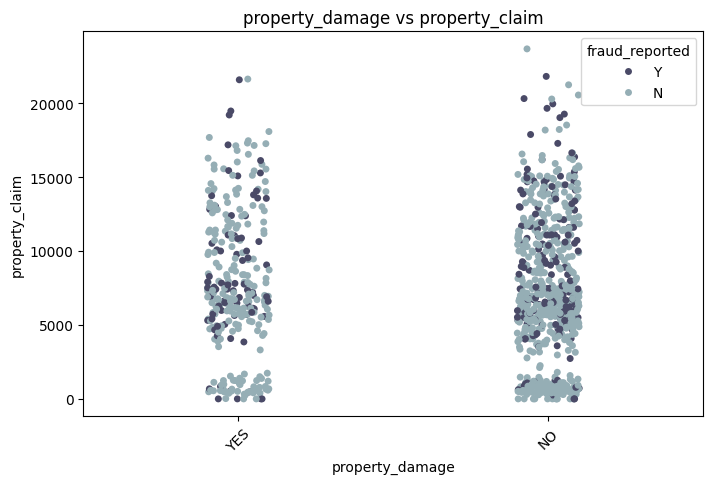

In [ ]:
plot_relationship(
    df=df,
    x_col='property_damage',
    y_col='property_claim',
    hue_col='fraud_reported',
)

Fraud cases are more common when property damage is reported as 'YES' 78/302 = approx 25.8% as compared to when property damage is reported as 'NO' 169/698 = approx 19.5%. However, amount of fraud claims when property damage is reported as 'YES' is still more than when property damage is reported as 'NO'.

<ipython-input-47-88fba967665a>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




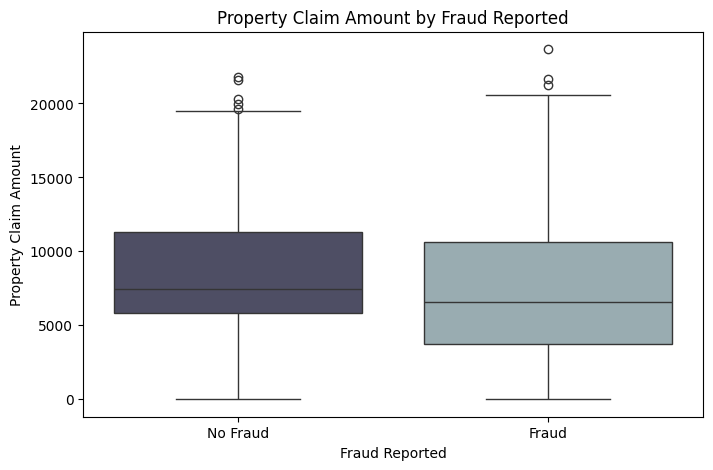

In [ ]:
plt.rcParams['figure.figsize'] = (8, 5)

sns.boxplot(x=df['fraud_reported'], y=df['property_claim'], palette='bone')

plt.title('Property Claim Amount by Fraud Reported')
plt.xlabel('Fraud Reported')
plt.ylabel('Property Claim Amount')
plt.xticks([0, 1], ['No Fraud', 'Fraud'])
plt.show()

The boxplot above shows that both fraud and non-fraud cases have clusters at lower claim values, with some high-value outliers, therefore following a similar distribution.

fraud_reported              N    Y
incident_type                     
Multi-vehicle Collision   305  114
Parked Car                 76    8
Single Vehicle Collision  286  117
Vehicle Theft              86    8


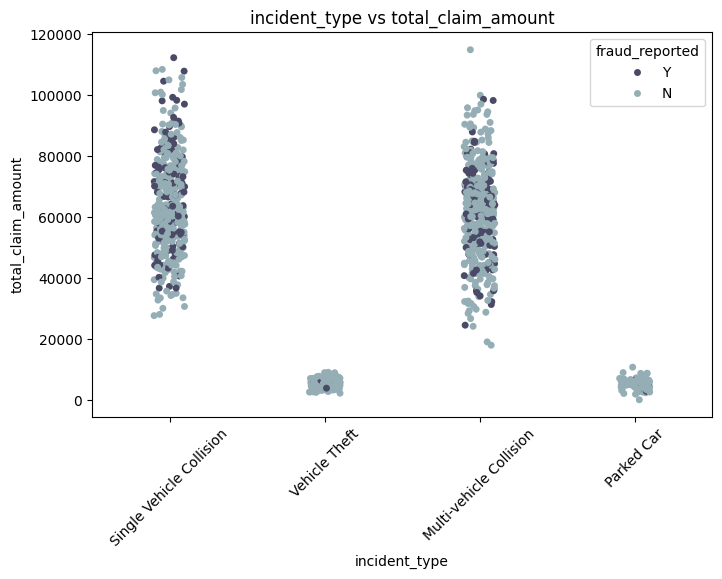

In [ ]:
# Plot to visualize Total claim amount vs Incident type
plot_relationship(
    df=df,
    x_col='incident_type',
    y_col='total_claim_amount',
    hue_col='fraud_reported',
)

We can see that for each incident_type, fraud claims and non-fraud claims follows a similar claim distribution. However, there seems to be a larger percentage of fraud claims happening when the incident involves vehicle collision.

<ipython-input-49-3356566117c7>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




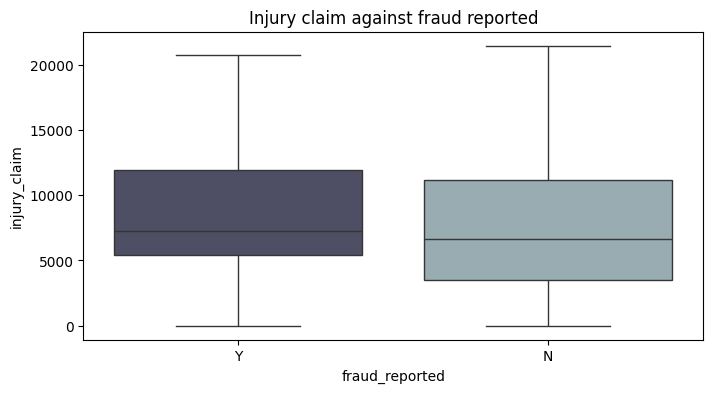

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['fraud_reported'], y=df['injury_claim'], palette='bone')
plt.title('Injury claim against fraud reported')
plt.show()

Fraud cases have a slightly higher median injury claim, suggesting that fraudulent claims often involve larger compensation requests.

<ipython-input-50-95cf339bd5d3>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




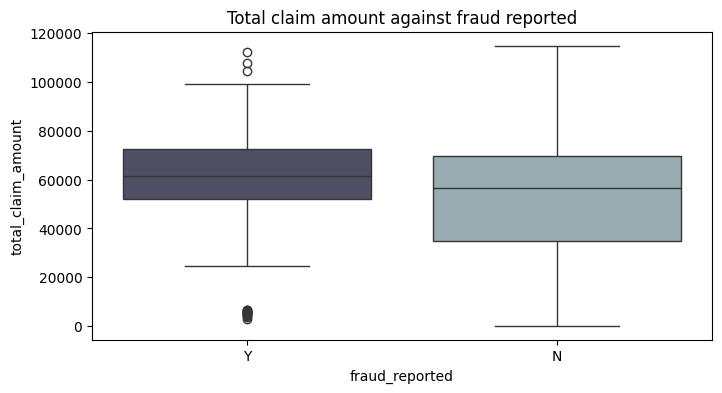

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['fraud_reported'], y=df['total_claim_amount'], palette='bone')
plt.title('Total claim amount against fraud reported')
plt.show()

We can see that the median for fraud claims is slightly higher compared to non-fraud claims, with outliers being both extremely high and extremely low claim amounts. This indicates that fraudsters may either inflate damages significantly (resulting in high-value claims) or fabricate small damages (resulting in low-value claims to avoid detection).



In [ ]:
fraud_counts = df.groupby(['bodily_injuries', 'fraud_reported']).size().unstack(fill_value=0)
print(fraud_counts)

fraud_reported     N   Y
bodily_injuries         
0                260  80
1                251  77
2                242  90


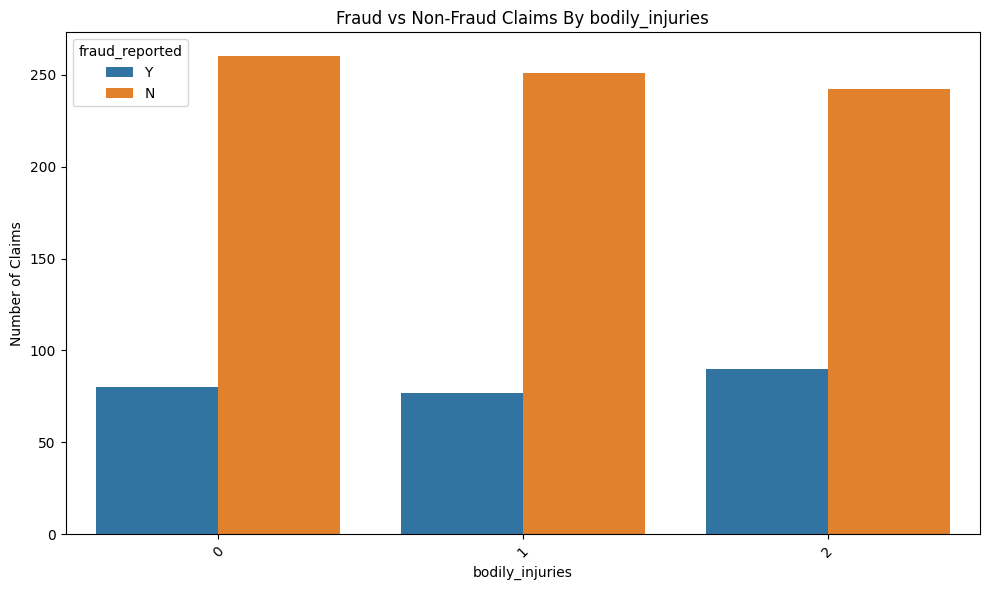

In [ ]:
fraud_vs_nonfraud_plot(df, 'bodily_injuries', 'fraud_reported')

We can see that fraud claims are quite well distributed despite the number of bodily injuries with bodily injuries = 2 being slightly higher.

In [ ]:
fraud_counts = df.groupby(['authorities_contacted', 'fraud_reported']).size().unstack(fill_value=0)
print(fraud_counts)
print('-'*100)
fraud_counts['Fraud_Percentage'] = (fraud_counts['Y'] / (fraud_counts['N'] + fraud_counts['Y'])) * 100
print(fraud_counts[['Fraud_Percentage']])

fraud_reported           N   Y
authorities_contacted         
Ambulance              139  57
Fire                   163  60
Other                  220  69
Police                 231  61
----------------------------------------------------------------------------------------------------
fraud_reported         Fraud_Percentage
authorities_contacted                  
Ambulance                     29.081633
Fire                          26.905830
Other                         23.875433
Police                        20.890411


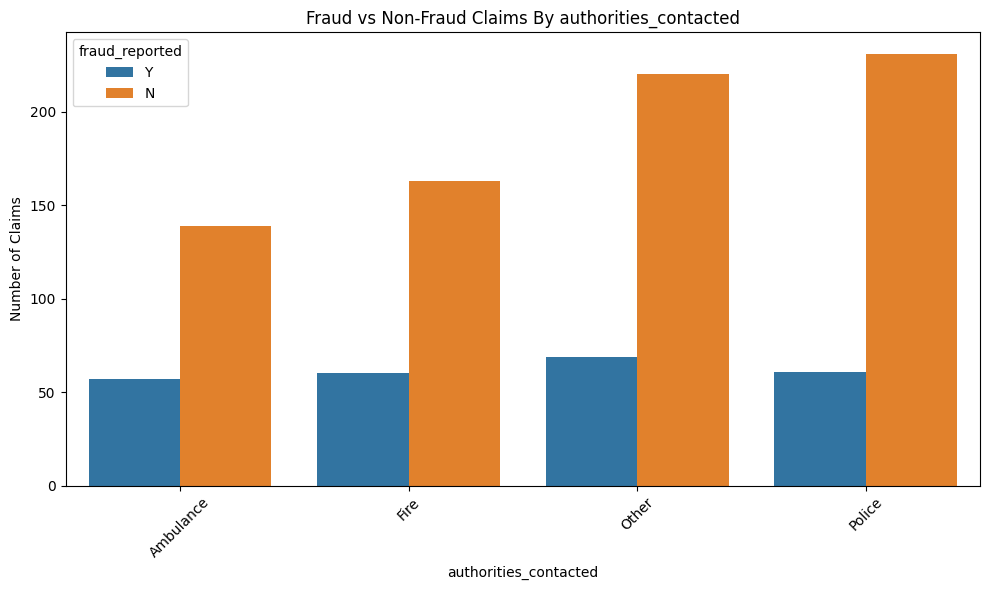

In [ ]:
fraud_vs_nonfraud_plot(df, 'authorities_contacted', 'fraud_reported')

The number of fraud claims remains consistent, regardless of the authorities contacted. However, there appears to be a higher percentage of fraud claims when emergency services like ambulance or fire fighters are involved. This could suggest that incidents requiring such authorities tend to be of a larger scale and may present more opportunities for fraudulent activity.

In [ ]:
fraud_counts = df.groupby(['auto_year', 'fraud_reported']).size().unstack(fill_value=0)
print(fraud_counts)

fraud_reported   N   Y
auto_year             
1995            43  13
1996            23  14
1997            34  12
1998            33   7
1999            45  10
2000            31  11
2001            33   9
2002            39  10
2003            42   9
2004            23  16
2005            42  12
2006            39  14
2007            34  18
2008            35  10
2009            39  11
2010            43   7
2011            36  17
2012            37   9
2013            34  15
2014            32  12
2015            36  11


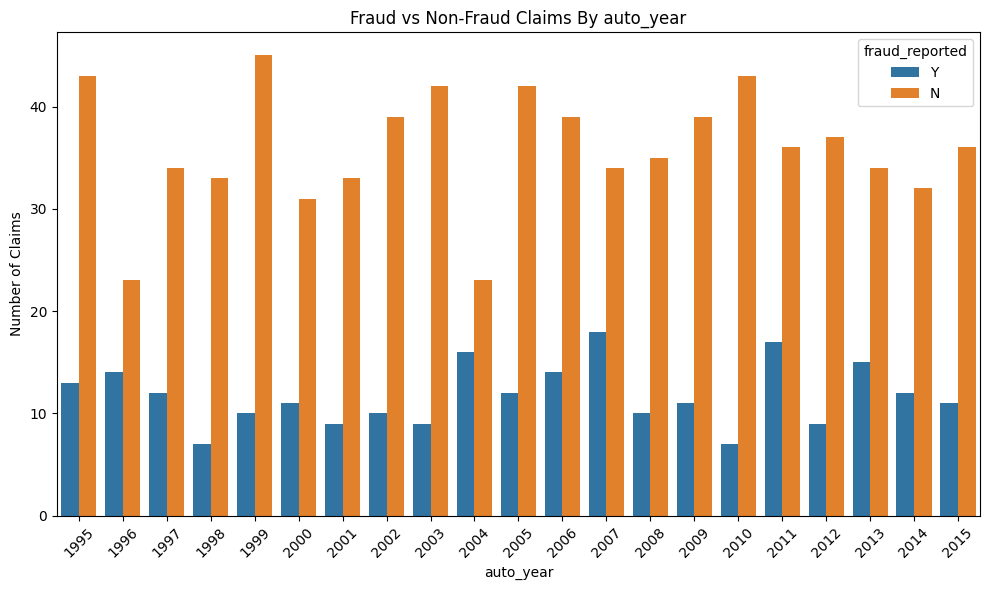

In [ ]:
fraud_vs_nonfraud_plot(df, 'auto_year', 'fraud_reported')

The number of fraud claims varies year over year.

In [ ]:
fraud_counts = df.groupby(['auto_make', 'fraud_reported']).size().unstack(fill_value=0)
print(fraud_counts)
print('-'*100)
fraud_counts['Fraud_Percentage'] = (fraud_counts['Y'] / (fraud_counts['N'] + fraud_counts['Y'])) * 100
print(fraud_counts[['Fraud_Percentage']])

fraud_reported   N   Y
auto_make             
Accura          55  13
Audi            48  21
BMW             52  20
Chevrolet       55  21
Dodge           60  20
Ford            50  22
Honda           41  14
Jeep            56  11
Mercedes        43  22
Nissan          64  14
Saab            62  18
Suburu          61  19
Toyota          57  13
Volkswagen      49  19
----------------------------------------------------------------------------------------------------
fraud_reported  Fraud_Percentage
auto_make                       
Accura                 19.117647
Audi                   30.434783
BMW                    27.777778
Chevrolet              27.631579
Dodge                  25.000000
Ford                   30.555556
Honda                  25.454545
Jeep                   16.417910
Mercedes               33.846154
Nissan                 17.948718
Saab                   22.500000
Suburu                 23.750000
Toyota                 18.571429
Volkswagen             27.941176


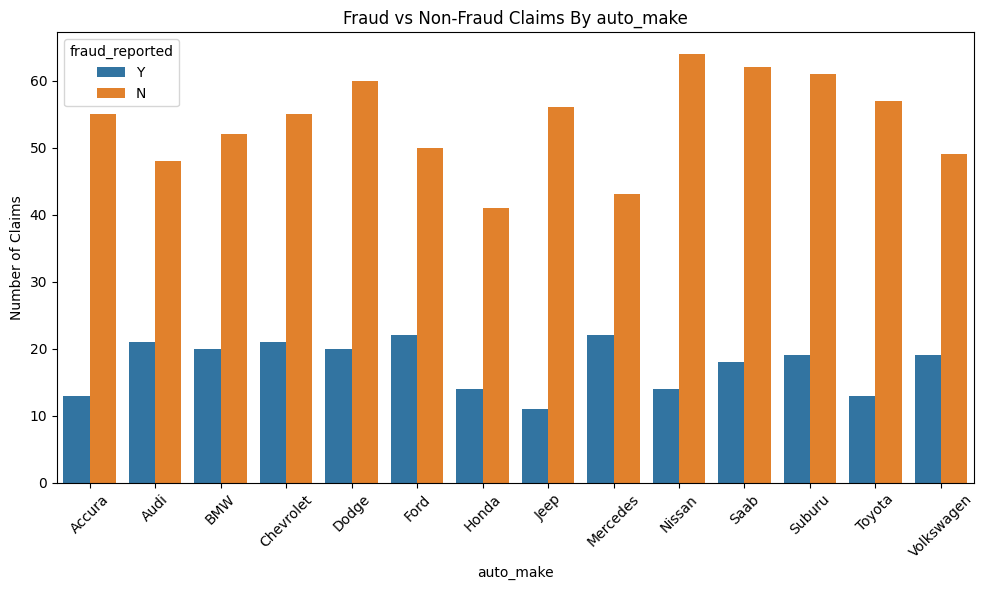

In [ ]:
fraud_vs_nonfraud_plot(df, 'auto_make', 'fraud_reported')

Car brands like Audi, Mercedes and Ford have a higher fraud rate as compared to the other brands.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Usage
cramers_v(df['auto_make'], df['auto_model'])


np.float64(0.9872411207126471)

As we can see, auto_make and auto_model is highly correlated so a new feature should be engineered to reduce redundancy.

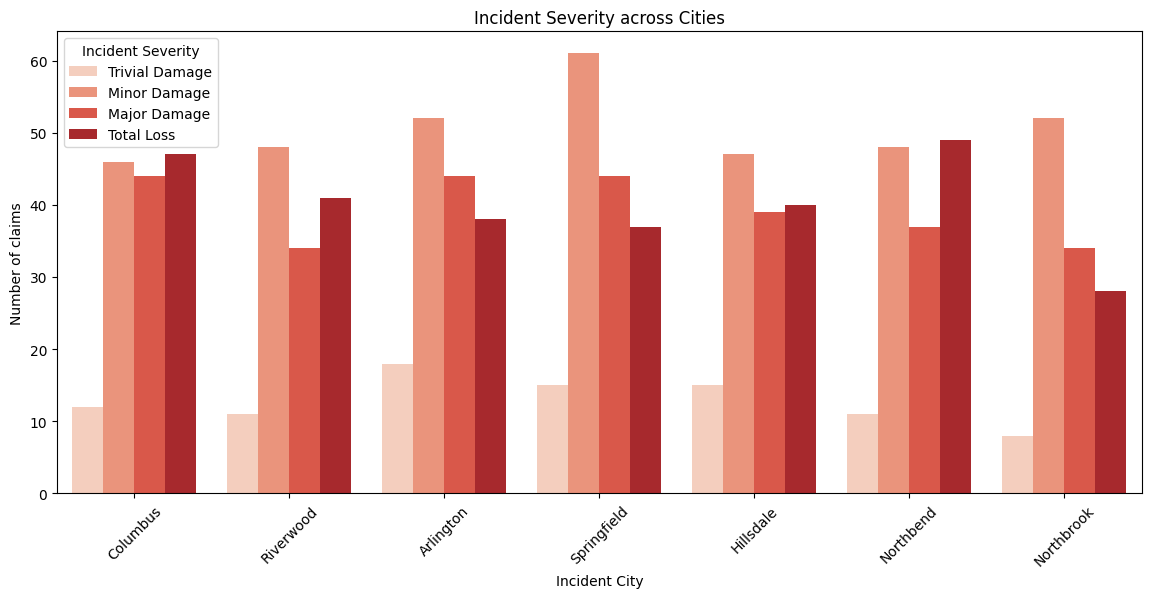

In [ ]:
order = ['Trivial Damage','Minor Damage','Major Damage','Total Loss']

df['incident_severity'] = pd.Categorical(df['incident_severity'], categories=order, ordered=True)

plt.figure(figsize=(14, 6))
sns.countplot(x=df['incident_city'], hue=df['incident_severity'], palette='Reds')
plt.xticks(rotation=45)
plt.title('Incident Severity across Cities')
plt.xlabel('Incident City')
plt.ylabel('Number of claims')
plt.legend(title='Incident Severity')
plt.show()

Claims for minor damage incidents are typically more common across all cities compared to those for other levels of incident severity.

In [ ]:
minor_damage_claims = df[df['incident_severity'] == 'Trivial Damage']
fraud_non_fraud_counts = minor_damage_claims['fraud_reported'].value_counts()
fraud_percentage = (fraud_non_fraud_counts.get(1, 0) / fraud_non_fraud_counts.sum()) * 100

print(fraud_non_fraud_counts)
print(f"Percentage of fraud claims: {fraud_percentage:.2f}%")

fraud_reported
N    84
Y     6
Name: count, dtype: int64
Percentage of fraud claims: 6.67%


<ipython-input-61-0b8ff368a038>:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [ ]:
minor_damage_claims = df[df['incident_severity'] == 'Minor Damage']
fraud_non_fraud_counts = minor_damage_claims['fraud_reported'].value_counts()
fraud_percentage = (fraud_non_fraud_counts.get(1, 0) / fraud_non_fraud_counts.sum()) * 100

print(fraud_non_fraud_counts)
print(f"Percentage of fraud claims: {fraud_percentage:.2f}%")

fraud_reported
N    316
Y     38
Name: count, dtype: int64
Percentage of fraud claims: 10.73%


<ipython-input-62-9763635f416b>:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [ ]:
minor_damage_claims = df[df['incident_severity'] == 'Major Damage']
fraud_non_fraud_counts = minor_damage_claims['fraud_reported'].value_counts()
fraud_percentage = (fraud_non_fraud_counts.get(1, 0) / fraud_non_fraud_counts.sum()) * 100

print(fraud_non_fraud_counts)
print(f"Percentage of fraud claims: {fraud_percentage:.2f}%")

fraud_reported
Y    167
N    109
Name: count, dtype: int64
Percentage of fraud claims: 39.49%


<ipython-input-63-1a86d59c4385>:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [ ]:
minor_damage_claims = df[df['incident_severity'] == 'Total Loss']
fraud_non_fraud_counts = minor_damage_claims['fraud_reported'].value_counts()
fraud_percentage = (fraud_non_fraud_counts.get(1, 0) / fraud_non_fraud_counts.sum()) * 100

print(fraud_non_fraud_counts)
print(f"Percentage of fraud claims: {fraud_percentage:.2f}%")

fraud_reported
N    244
Y     36
Name: count, dtype: int64
Percentage of fraud claims: 12.86%


<ipython-input-64-3fb15ec3919f>:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



However, it is interesting how incident severity with Major Damage has a very large percentage of fraud claims as compared to the other incident severity.

In [ ]:
fraud_counts = df.groupby(['incident_hour_of_the_day', 'fraud_reported']).size().unstack(fill_value=0)
print(fraud_counts)

fraud_reported             N   Y
incident_hour_of_the_day        
0                         40  12
1                         21   8
2                         21  10
3                         41  12
4                         38   8
5                         24   9
6                         30  14
7                         32   8
8                         30   6
9                         39   4
10                        31  15
11                        18  12
12                        32   8
13                        38   8
14                        28  15
15                        26  13
16                        33  16
17                        46   8
18                        27  14
19                        31   9
20                        25   9
21                        32  10
22                        33   5
23                        37  14


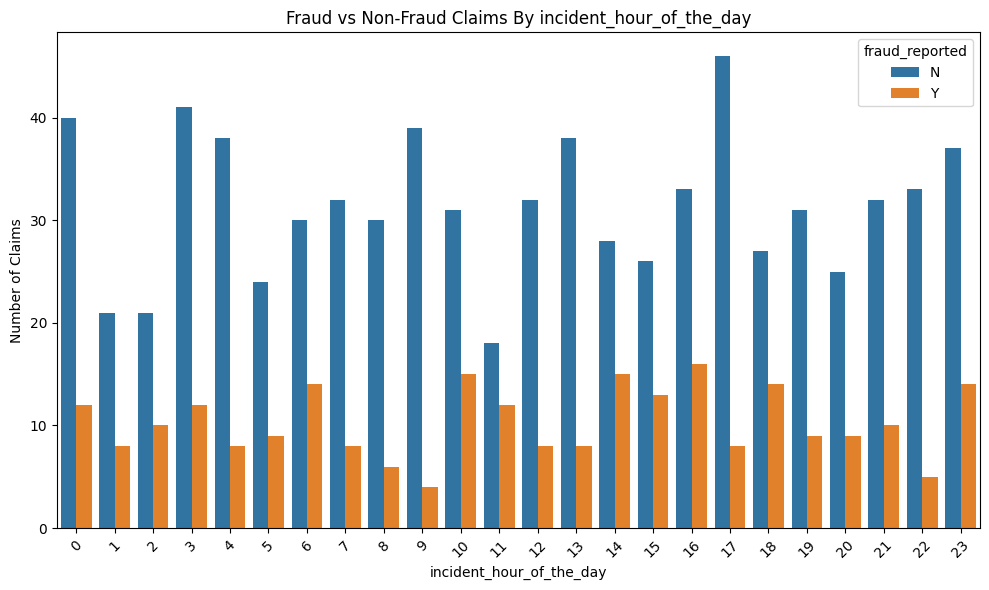

In [ ]:
fraud_vs_nonfraud_plot(df, 'incident_hour_of_the_day', 'fraud_reported')

Fraud claims is inconsistent throughout the day.

fraud_reported         N    Y
incident_month_year          
2015-01              381  135
2015-02              364  108
2015-03                8    4


<Figure size 1000x600 with 0 Axes>

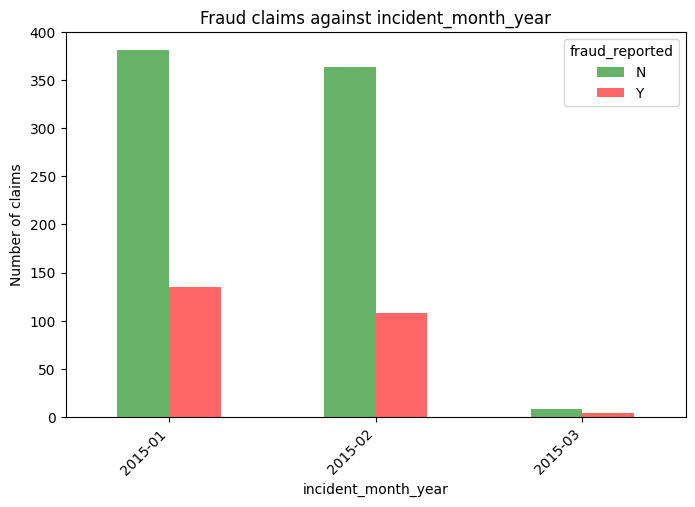

In [ ]:
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['incident_month_year'] = df['incident_date'].dt.to_period('M')
fraud_counts = df.groupby(['incident_month_year', 'fraud_reported']).size().unstack(fill_value=0)
print(fraud_counts)

plt.figure(figsize=(10, 6))
fraud_counts = df.groupby(['incident_month_year', 'fraud_reported']).size().unstack(fill_value=0)
fraud_counts.plot(kind='bar', figsize=(8, 5), color=['green', 'red'], alpha=0.6)

plt.title('Fraud claims against incident_month_year')
plt.xlabel('incident_month_year')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of claims')
plt.legend(title='fraud_reported')
plt.show()

df = df.drop(['incident_month_year'], axis = 1)

No meaningful insights can be drawn from the incident_month_year column, as it contains data for only three months. Furthermore, number of claims in 2015-01 and 2015-02 are significantly higher than 2015-03 suggesting that collection of data probably stopped early 2015-03.

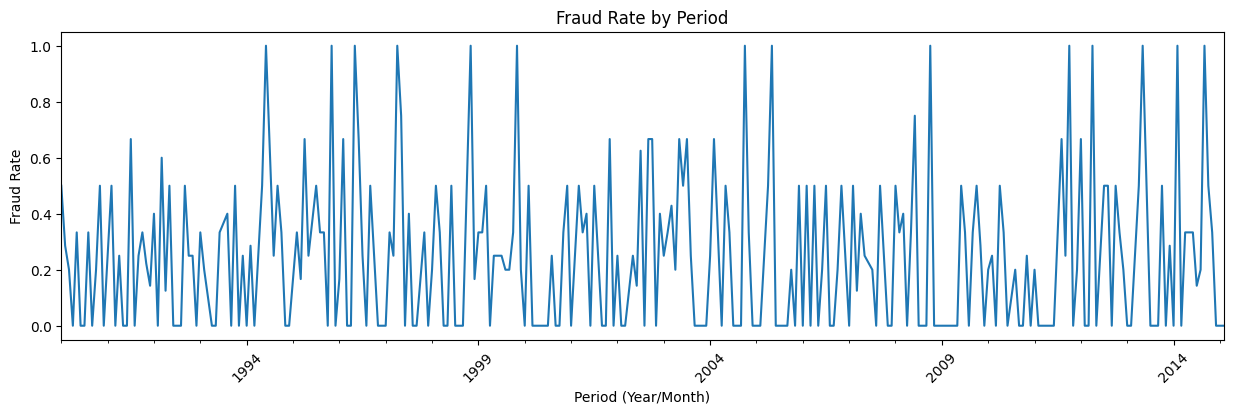

In [ ]:
# Visualize fraud rate over time based on policy_bind_date
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['policy_month_year'] = df['policy_bind_date'].dt.to_period('M')  # Group by month-year

fraud_analysis = df.groupby(['policy_month_year', 'fraud_reported']).size().unstack(fill_value=0)
fraud_rate = fraud_analysis['Y'] / (fraud_analysis['Y'] + fraud_analysis['N'])

plt.figure(figsize=(15, 4))
fraud_rate.plot(kind='line', title='Fraud Rate by Period')
plt.xlabel('Period (Year/Month)')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()

The fraud rate fluctuates significantly across different policy_bind periods.
This suggests that fraud occurrences are inconsistent over time, potentially influenced by external factors.

In [ ]:
df.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported',
       'incident_minus_policy_bind_date', 'age_range',
       'months_as_customer_range', 'policy_month_year'],
      dtype='object')

In [ ]:
# Reasons for dropping the respective columns
# policy_number: is just a unique idenitifier to assigned to each policyholder
# policy_bind_date: has no significance to the date alone
# incident_date: has no significance to the date alone
# incident_location: insured_zip is a good enough indicator which is more interpretable
# df = df.drop(['policy_number','policy_bind_date', 'incident_date','incident_location', 'policy_month_year', 'long_lat'], axis = 1)

df = df.drop(['policy_number','policy_bind_date', 'incident_date','incident_location', 'policy_month_year'], axis = 1)

In [ ]:
# remove columns where we created groups for

df = df.drop(['age', 'months_as_customer'], axis = 1)

#Feature Engineering

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Initialize OrdinalEncoder
encoder = OrdinalEncoder(categories=[['Trivial Damage', 'Minor Damage', 'Major Damage', 'Total Loss']])

# Fit and transform the 'incident_severity' column
df['incident_severity_encoded'] = encoder.fit_transform(df[['incident_severity']])

df = df.drop(['incident_severity'], axis = 1)

In [ ]:
quantitative_cols = df.select_dtypes(include='number').columns
categorical_cols = df.select_dtypes(include='object').columns

for column in categorical_cols:
    unique_values = df[column].unique()
    print(f"Unique '{column}': {unique_values}")
print('-'*100)
for column in quantitative_cols:
    max_values = df[column].max()
    min_values = df[column].min()
    print(f"Column '{column}': Min = {min_values}, Max = {max_values}")

Unique 'policy_bind_date': ['2014-10-17' '2006-06-27' '2000-09-06' '1990-05-25' '2014-06-06'
 '2006-10-12' '2000-06-04' '1990-02-03' '1997-02-05' '2011-07-25'
 '2002-05-26' '1999-05-29' '1997-11-20' '2012-10-26' '1998-12-28'
 '1992-10-19' '2005-06-08' '2004-11-15' '2014-12-28' '1992-08-02'
 '2002-06-25' '2005-11-27' '1994-05-27' '1991-02-08' '1996-02-02'
 '2013-12-05' '1990-09-20' '2002-07-18' '1990-02-08' '2014-03-04'
 '2000-02-18' '2008-06-19' '2003-08-01' '1992-04-04' '1991-01-13'
 '2010-08-08' '2003-03-09' '1993-02-03' '2002-11-25' '1997-07-27'
 '1995-05-08' '2012-08-30' '2006-04-30' '2003-04-13' '2007-12-05'
 '2006-08-21' '1990-01-08' '1990-03-18' '2008-01-07' '1997-03-10'
 '2004-01-10' '1994-08-20' '2002-06-02' '1994-04-28' '2014-08-17'
 '2007-08-11' '2008-11-20' '1995-10-18' '1993-05-19' '2005-02-26'
 '1990-02-14' '1993-09-30' '2014-06-10' '2008-10-28' '2007-04-24'
 '1993-12-13' '2011-08-17' '1990-08-20' '1994-02-11' '1994-02-22'
 '2011-08-15' '1998-11-11' '1995-12-04' '2002-12-

In [ ]:
# Combine auto_make and auto_model as they are highly correlated
df['auto_make_model'] = df['auto_make'] + '_' + df['auto_model']
df = df.drop(['auto_make', 'auto_model'], axis = 1)

categorical_cols = df.select_dtypes(include='object').columns

In [ ]:
# Pick out columns with many unique values for Target encoding
#target_encoding_col = ['insured_occupation', 'auto_make', 'auto_model']

one_hot_col = [col for col in categorical_cols if col != 'fraud_reported' and col != 'incident_severity_encoded']

In [ ]:
print(one_hot_col)

['policy_bind_date', 'policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_date', 'incident_type', 'collision_type', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'property_damage', 'police_report_available', 'age_range', 'months_as_customer_range', 'auto_make_model']


In [ ]:
df_encoded = pd.get_dummies(df, columns=one_hot_col, drop_first=True)

In [ ]:
df_encoded['fraud_reported'] = df_encoded['fraud_reported'].apply(lambda x: 1 if x == 'Y' else 0)

In [ ]:
print(f"Number of columns: {len(df_encoded.columns)}")
# get shape
print(f"Shape of df: {df_encoded.shape}")

Number of columns: 2122
Shape of df: (1000, 2122)


In [ ]:
# save df to drive
df_encoded.to_csv(r"../data/processed/processed_data.csv", index=False)

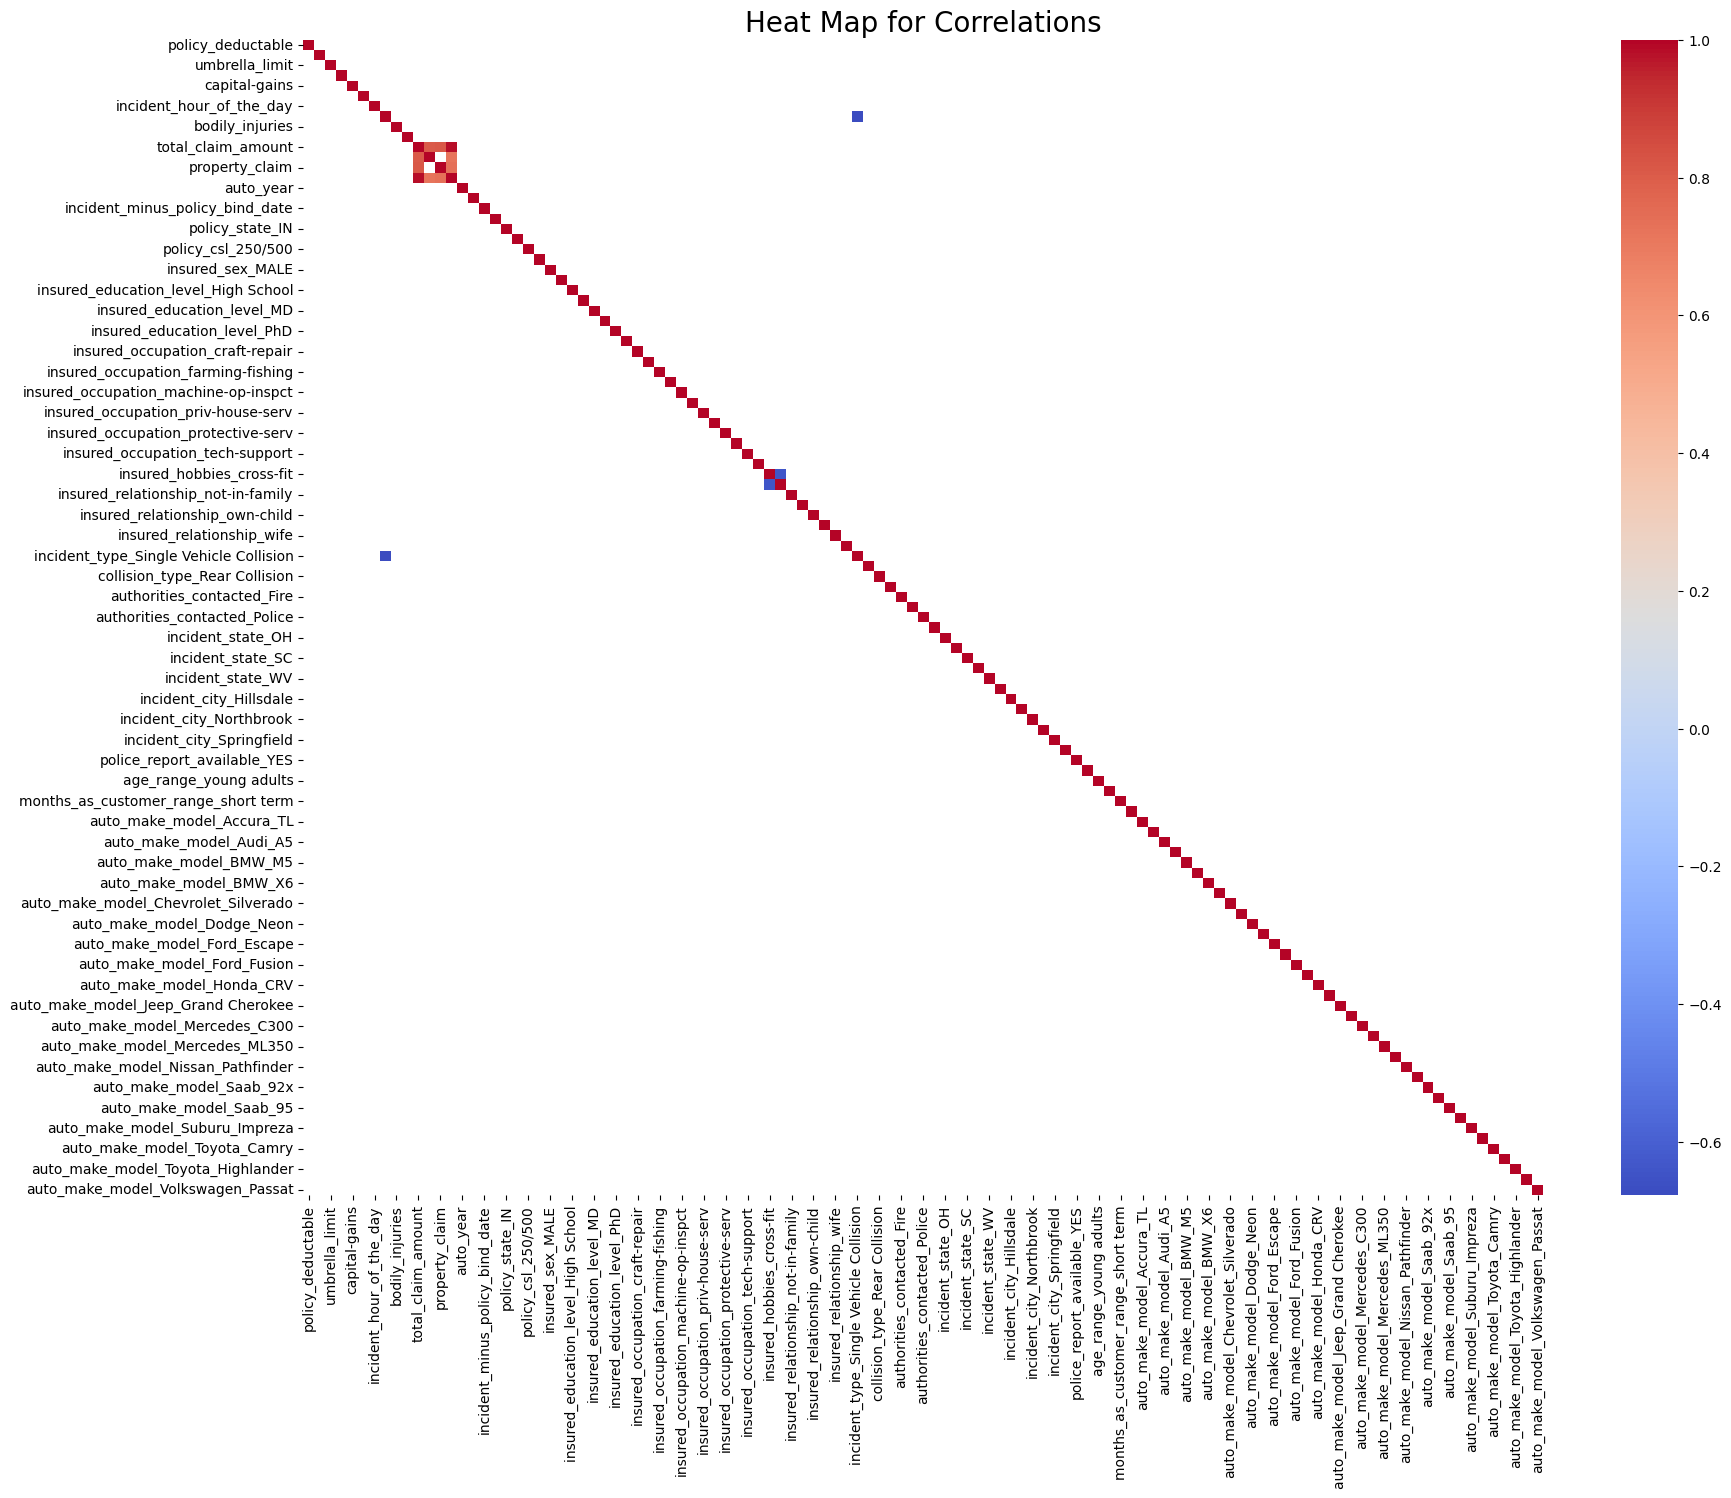

In [ ]:
# Correlation map
corr_matrix = df_encoded.corr()
threshold = 0.6
corr_matrix[(corr_matrix.abs() < threshold)] = np.nan

# Plot the heatmap with a larger figure size
plt.rcParams['figure.figsize'] = (20, 15)
sns.heatmap(corr_matrix, cmap = 'coolwarm')
plt.title('Heat Map for Correlations', fontsize = 20)
plt.show()

We can see that injury_claim, vehicle_claim and property_claim is highly correlated to total_claim_amount. It may be due to the fact that total_claim_amount is the sum of injury_claim + vehicle_claim + property_claim.

In [ ]:
# To confirm our suspicions
df['is_total_claim_correct'] = (df['total_claim_amount'] == df['vehicle_claim'] + df['injury_claim'] + df['property_claim'])
incorrect_claims = df[df['is_total_claim_correct'] == False]
print(f"Number of incorrect rows: {len(incorrect_claims)}")
df = df.drop(['is_total_claim_correct'], axis = 1)

Number of incorrect rows: 0


In [ ]:
# Drop vehicle_claim, property_claim and injury_claim as total_claim_amount has already captured the necessary information
df = df.drop(['vehicle_claim', 'property_claim', 'injury_claim'], axis = 1)

# Baseline model
 Logistic regression was chosen as a baseline model due to its simplicity and interpretability. For the baseline comparison, the logistic regression model was trained on the raw data without any of the engineered features.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

target_col = "fraud_reported"
X = df.drop(target_col, axis=1)
X = X.drop(columns=X.select_dtypes(include=['object', 'string', 'category']).columns)
y = df['fraud_reported'].map({"Y":1,"N":0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
# Predictions
y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)

# Evaluation

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# AUC-ROC
auc = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC: {auc:.4f}")

print("Precision:")
print(precision_score(y_test, y_pred))

print("F1-score:")
print(f1_score(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Recall:")
print(recall_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7250
AUC-ROC: 0.5056
Precision:
0.5
F1-score:
0.03508771929824561
Confusion Matrix:
[[144   1]
 [ 54   1]]
Recall:
0.01818181818181818

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.99      0.84       145
           1       0.50      0.02      0.04        55

    accuracy                           0.72       200
   macro avg       0.61      0.51      0.44       200
weighted avg       0.66      0.72      0.62       200



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report
from itertools import product
import numpy as np

target_col = "fraud_reported"
X = new_df.drop(target_col, axis=1)
X = X.drop(columns=X.select_dtypes(include=['object', 'string', 'category']).columns)
y = new_df['fraud_reported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# parameter search space
C_vals = np.logspace(-4, 2, 10)  # [0.0001 to 100]
penalties = ['l1', 'l2', 'elasticnet', None]
solvers = ['liblinear', 'saga', 'lbfgs', 'newton-cg']
weights = [None, 'balanced']
l1_ratios = [None, 0.1, 0.3, 0.5, 0.7, 0.9]

# Filter valid combinations
param_list = []
for C, penalty, solver, weight, l1_ratio in product(C_vals, penalties, solvers, weights, l1_ratios):
    if penalty == 'l1' and solver not in ['liblinear', 'saga']:
        continue
    if penalty == 'elasticnet' and solver != 'saga':
        continue
    if penalty == None and solver not in ['lbfgs', 'saga', 'newton-cg']:
        continue
    if penalty == 'l2' and solver not in ['liblinear', 'lbfgs', 'saga', 'newton-cg']:
        continue
    if penalty != 'elasticnet' and l1_ratio is not None:
        continue
    if penalty == 'elasticnet' and l1_ratio is None:
        continue
    param_list.append({
        'C': C,
        'penalty': penalty,
        'solver': solver,
        'class_weight': weight,
        'l1_ratio': l1_ratio
    })

print('Hyperparameter tuning for Logistic Regresion with RandomizedSearchCV...')
# Run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_distributions={'params': param_list},
    scoring='recall',  # or 'roc_auc'
    n_iter=50,  # try increasing to 100+ if needed
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# unpack 'params' dicts
class UnpackLogisticRegression(LogisticRegression):
    def set_params(self, **params):
        subparams = params.get("params", {})
        return super().set_params(**subparams)

random_search.estimator = UnpackLogisticRegression()

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)

# Evaluate best model
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Hyperparameter tuning for Logistic Regresion with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'params': {'C': np.float64(0.01), 'penalty': None, 'solver': 'newton-cg', 'class_weight': 'balanced', 'l1_ratio': None}}
Accuracy: 0.6000
AUC-ROC: 0.6003
Precision: 0.3377
Recall: 0.4727
F1-score: 0.3939

Confusion Matrix:
 [[94 51]
 [29 26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.65      0.70       145
           1       0.34      0.47      0.39        55

    accuracy                           0.60       200
   macro avg       0.55      0.56      0.55       200
weighted avg       0.65      0.60      0.62       200



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/optimize.py:319: ConvergenceWarning: newton-cg failed to converge at loss = 0.4943434544911012. Increase the number of iterations.
  warnings.warn(


In [28]:
from sklearn.model_selection import GridSearchCV

# Prepare the data (assuming df is already defined)
X = new_df.drop('fraud_reported', axis=1)  # Replace 'fraud_reported' with your column name
X = X.drop(columns=X.select_dtypes(include=['object', 'string']).columns)  # Drop object/string columns

y = new_df['fraud_reported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = LogisticRegression(max_iter=1000)

# Hyperparameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization type
    'solver': ['lbfgs', 'liblinear'],  # Optimizer choice
    'class_weight': [None, 'balanced'],  # Handle class imbalance
}

# Initialize GridSearchCV with Logistic Regression model
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',  # AUC-ROC is commonly used for binary classification problems
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=2  # Print progress
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best AUC-ROC: {grid_search.best_score_:.4f}")

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)

# Evaluation
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# AUC-ROC
auc = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC: {auc:.4f}")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Best AUC-ROC: 0.5838
Accuracy: 0.5450
AUC-ROC: 0.5688
Confusion Matrix:
[[84 61]
 [30 25]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.58      0.65       145
           1       0.29      0.45      0.35        55

    accuracy                           0.55       200
   macro avg       0.51      0.52      0.50       200
weighted avg       0.61      0.55      0.57       200



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Over and under sampling
Due to class imbalance, we decided to use over sampling methods to generate more data points for event when it is a fraud.

Both SMOTE and ADASYN were experimented and we attempt to find out which method is better.

In [6]:
new_df = pd.read_csv("../data/processed/processed_data.csv")
new_df.head()

,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,...,auto_make_model_Saab_93,auto_make_model_Saab_95,auto_make_model_Suburu_Forrestor,auto_make_model_Suburu_Impreza,auto_make_model_Suburu_Legacy,auto_make_model_Toyota_Camry,auto_make_model_Toyota_Corolla,auto_make_model_Toyota_Highlander,auto_make_model_Volkswagen_Jetta,auto_make_model_Volkswagen_Passat
0,1000,1406.91,0,466132,53300,0,5,1,1,2,...,False,False,False,False,False,False,False,False,False,False
1,2000,1197.22,5000000,468176,0,0,8,1,0,0,...,False,False,False,False,False,False,False,False,False,False
2,2000,1413.14,5000000,430632,35100,0,7,3,2,3,...,False,False,False,False,False,False,False,False,False,False
3,2000,1415.74,6000000,608117,48900,-62400,5,1,1,2,...,False,False,False,False,False,False,False,False,False,False
4,1000,1583.91,6000000,610706,66000,-46000,20,1,0,1,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 113 entries, policy_deductable to auto_make_model_Volkswagen_Passat
dtypes: bool(95), float64(2), int64(16)
memory usage: 233.5 KB


In [ ]:
X = new_df.drop(columns=['fraud_reported'])
y = new_df['fraud_reported'].round().astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [ ]:
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

X_ada, y_ada = ADASYN(random_state=42).fit_resample(X_train, y_train)

over = SMOTE(sampling_strategy=0.5, random_state=42)   # minority becomes 0.5 * majority (~800 * 0.75)
under = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # majority becomes equal to minority

resample_pipeline = Pipeline(steps=[
    ('o', over),
    ('u', under)
])

X_smote, y_smote = resample_pipeline.fit_resample(X_train, y_train)

print(f'Before ADASYN: {Counter(y_train)}, After ADASYN: {Counter(y_ada)}')
print(f'Before SMOTE: {Counter(y_train)}, After SMOTE: {Counter(y_smote)}')

Before ADASYN: Counter({0: 608, 1: 192}), After ADASYN: Counter({1: 609, 0: 608})
Before SMOTE: Counter({0: 608, 1: 192}), After SMOTE: Counter({0: 304, 1: 304})


# Challenger Model 1
Both Decision Tree and Random Forest were attempted to compare performances.



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, make_scorer
)
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, make_scorer)


In [ ]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[2]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[3]

def build_pipeline(method='none', model_type='decision_tree'):
    steps=[]
    # Choose sampler
    if method == 'smote':
        steps.append(('oversample', SMOTE(random_state=42)))
    elif method == 'adasyn':
        steps.append(('oversample', ADASYN(random_state=42)))
    elif method == 'smote_under':
        steps.append(('smote', SMOTE(random_state=42)))
        steps.append(('under', RandomUnderSampler(random_state=42)))
    else:
        steps.append(('oversample', 'passthrough'))  # No sampling


    # Choose model
    if model_type == 'decision_tree':
        model = DecisionTreeClassifier(random_state=42)
    elif model_type == 'random_forest':
        model = RandomForestClassifier(random_state=42)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Build pipeline
    steps.append(('classifier', model))

    # Build pipeline
    pipeline = ImbPipeline(steps=steps)
    return pipeline

def get_confusion_matrix_and_report_from_pipeline(pipeline, X, y, test_size=0.2, random_state=42):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = pipeline.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    print(cm)
    print(classification_report(y_test, y_pred))


def cross_validate_model(pipeline, X, y, cv=5):
    # Define scoring
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score),
        'true_negatives': make_scorer(tn),
        'false_positives': make_scorer(fp),
        'false_negatives': make_scorer(fn),
        'true_positives': make_scorer(tp)
    }

    # Cross-validation scores (no predictions here)
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=True)

    print(f"\n=== {cv}-Fold Cross-Validation Metric Averages ===")
    for metric in ['train_accuracy', 'test_accuracy', 'test_precision', 'test_recall',
                   'test_f1', 'test_roc_auc', 'test_true_negatives', 'test_false_positives',
                   'test_false_negatives', 'test_true_positives']:
        avg = np.mean(cv_results[metric])
        print(f"{metric}: {avg:.4f}")


In [ ]:
X = new_df.drop(columns=['fraud_reported'])
y = new_df['fraud_reported']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

In [ ]:
pipeline = build_pipeline(method='none', model_type='decision_tree')
get_confusion_matrix_and_report_from_pipeline(pipeline, X, y)
cross_validate_model(pipeline, X, y)

[[125  26]
 [ 22  27]]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       151
           1       0.51      0.55      0.53        49

    accuracy                           0.76       200
   macro avg       0.68      0.69      0.68       200
weighted avg       0.77      0.76      0.76       200


=== 5-Fold Cross-Validation Metric Averages ===
train_accuracy: 1.0000
test_accuracy: 0.7750
test_precision: 0.5440
test_recall: 0.5673
test_f1: 0.5538
test_roc_auc: 0.7053
test_true_negatives: 127.0000
test_false_positives: 23.6000
test_false_negatives: 21.4000
test_true_positives: 28.0000


## Random Forest

In [ ]:
X = new_df.drop(columns=['fraud_reported'])
y = new_df['fraud_reported']

In [ ]:
pipeline = build_pipeline(method='none', model_type='random_forest')
get_confusion_matrix_and_report_from_pipeline(pipeline, X, y)
cross_validate_model(pipeline, X, y)

[[143   8]
 [ 42   7]]
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       151
           1       0.47      0.14      0.22        49

    accuracy                           0.75       200
   macro avg       0.62      0.54      0.53       200
weighted avg       0.70      0.75      0.70       200


=== 5-Fold Cross-Validation Metric Averages ===
train_accuracy: 1.0000
test_accuracy: 0.7790
test_precision: 0.6639
test_recall: 0.2066
test_f1: 0.3132
test_roc_auc: 0.5867
test_true_negatives: 145.6000
test_false_positives: 5.0000
test_false_negatives: 39.2000
test_true_positives: 10.2000


In [ ]:
pipeline = build_pipeline(method='smote', model_type='random_forest')
get_confusion_matrix_and_report_from_pipeline(pipeline, X, y)
cross_validate_model(pipeline, X, y)

[[137  14]
 [ 32  17]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       151
           1       0.55      0.35      0.42        49

    accuracy                           0.77       200
   macro avg       0.68      0.63      0.64       200
weighted avg       0.75      0.77      0.75       200


=== 5-Fold Cross-Validation Metric Averages ===
train_accuracy: 1.0000
test_accuracy: 0.7880
test_precision: 0.6391
test_recall: 0.3401
test_f1: 0.4392
test_roc_auc: 0.6375
test_true_negatives: 140.8000
test_false_positives: 9.8000
test_false_negatives: 32.6000
test_true_positives: 16.8000


In [ ]:
pipeline = build_pipeline(method='smote_under', model_type='random_forest')
get_confusion_matrix_and_report_from_pipeline(pipeline, X, y)
cross_validate_model(pipeline, X, y)

[[137  14]
 [ 33  16]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.85       151
           1       0.53      0.33      0.41        49

    accuracy                           0.77       200
   macro avg       0.67      0.62      0.63       200
weighted avg       0.74      0.77      0.74       200


=== 5-Fold Cross-Validation Metric Averages ===
train_accuracy: 1.0000
test_accuracy: 0.7870
test_precision: 0.6280
test_recall: 0.3317
test_f1: 0.4329
test_roc_auc: 0.6340
test_true_negatives: 141.0000
test_false_positives: 9.6000
test_false_negatives: 33.0000
test_true_positives: 16.4000


In [ ]:
pipeline = build_pipeline(method='adasyn', model_type='random_forest')
get_confusion_matrix_and_report_from_pipeline(pipeline, X, y)
cross_validate_model(pipeline, X, y)

[[142   9]
 [ 31  18]]
              precision    recall  f1-score   support

           0       0.82      0.94      0.88       151
           1       0.67      0.37      0.47        49

    accuracy                           0.80       200
   macro avg       0.74      0.65      0.68       200
weighted avg       0.78      0.80      0.78       200


=== 5-Fold Cross-Validation Metric Averages ===
train_accuracy: 1.0000
test_accuracy: 0.7870
test_precision: 0.6162
test_recall: 0.3519
test_f1: 0.4452
test_roc_auc: 0.6408
test_true_negatives: 140.0000
test_false_positives: 10.6000
test_false_negatives: 32.0000
test_true_positives: 17.4000


**Feature importance based on mean decrease in impurity**


Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

In [ ]:
import time
import numpy as np

start_time = time.time()
rf_model = pipeline.fit(X_train, y_train)
print(rf_model)
importances = rf_model.steps[1][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.steps[1][1].estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Pipeline(steps=[('oversample', ADASYN(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])
Elapsed time: 0.5148186683654785 seconds


incident_severity_encoded         0.131342
insured_hobbies_cross-fit         0.042436
total_claim_amount                0.037077
insured_zip                       0.036833
vehicle_claim                     0.036765
                                    ...   
auto_make_model_Ford_Fusion       0.000936
auto_make_model_BMW_3 Series      0.000898
auto_make_model_Toyota_Corolla    0.000878
auto_make_model_Accura_RSX        0.000815
auto_make_model_Honda_Accord      0.000754
Length: 112, dtype: float64


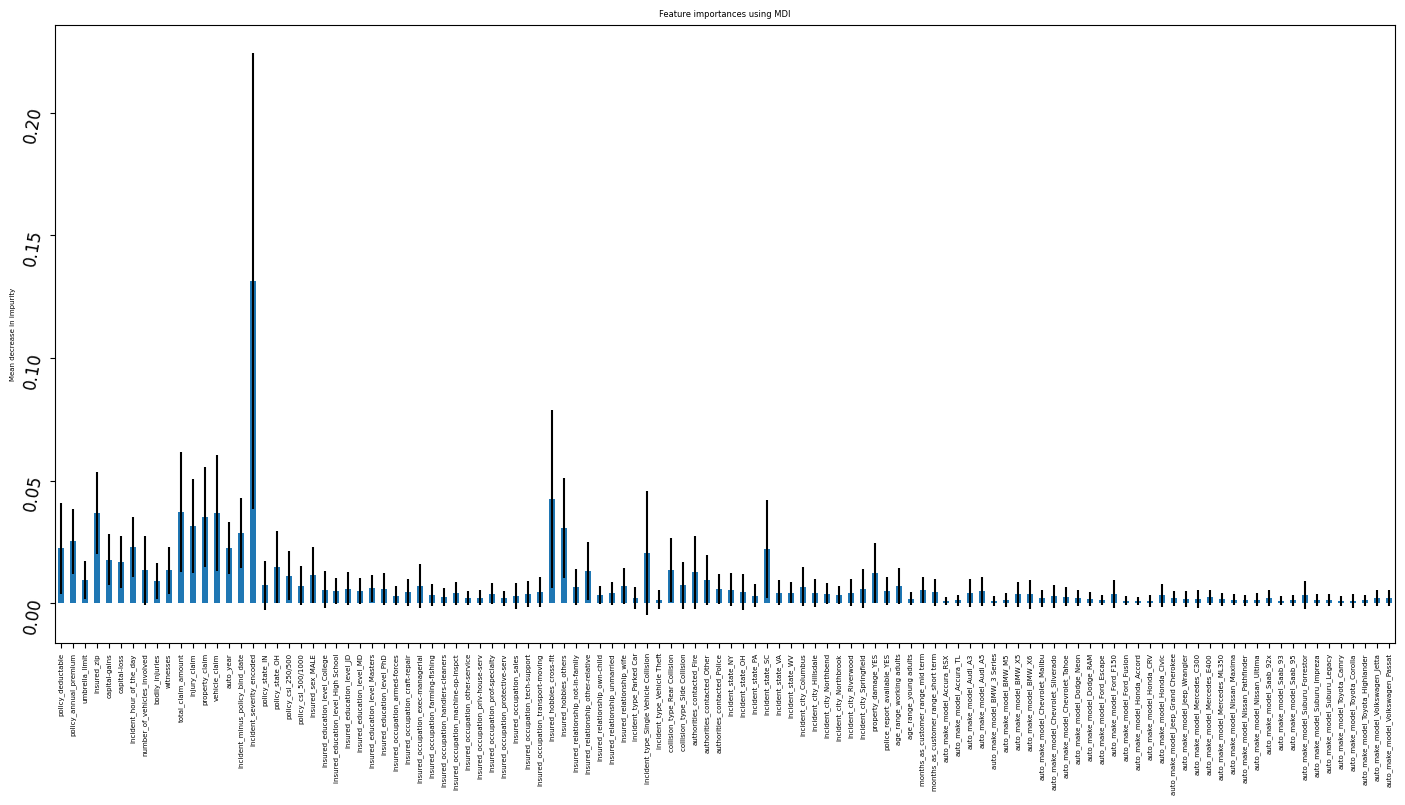

In [ ]:
feature_names = new_df.columns.tolist()
feature_names.remove('fraud_reported')
forest_importances = pd.Series(importances, index=feature_names)

feature_scores = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

print(feature_scores)

plt.rcParams.update({'font.size': 5})

fig, ax = plt.subplots(figsize=(14, 8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.yticks(rotation=80,fontsize=12)
fig.tight_layout()

In [ ]:
# Remove features with low importance (e.g., < 0.05)
indices = np.argsort(importances)[::-1]
important_features = [feature_names[i] for i in indices if importances[i] > 0.05]
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

# Re-train the Random Forest using only selected features
pipeline.fit(X_train_filtered, y_train)

# Get probability scores (for AUC-ROC evaluation)
y_test_proba = pipeline.predict_proba(X_test_filtered)[:, 1]

y_test_pred = pipeline.predict(X_test_filtered)


In [ ]:
y_train_pred = pipeline.predict(X_train_filtered)

rand_clf_train_acc = accuracy_score(y_train,y_train_pred)
rand_clf_test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training accuracy of Random Forest is : {rand_clf_train_acc}")
print(f"Test accuracy of Random Forest is : {rand_clf_test_acc}")

auc_roc = roc_auc_score(y_test, y_test_proba)
print("Test AUC-ROC Score:", auc_roc)

print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Training accuracy of Random Forest is : 0.80625
Test accuracy of Random Forest is : 0.83
Test AUC-ROC Score: 0.7886200837951075
[[130  21]
 [ 13  36]]
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       151
           1       0.63      0.73      0.68        49

    accuracy                           0.83       200
   macro avg       0.77      0.80      0.78       200
weighted avg       0.84      0.83      0.83       200





**Feature importance based on feature permutation**


Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

In [ ]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 17.390 seconds


incident_severity_encoded                 0.0860
insured_hobbies_others                    0.0265
insured_sex_MALE                          0.0200
insured_zip                               0.0165
insured_relationship_other-relative       0.0165
                                           ...  
age_range_working adults                 -0.0025
auto_make_model_Audi_A5                  -0.0030
collision_type_Side Collision            -0.0075
number_of_vehicles_involved              -0.0080
incident_type_Single Vehicle Collision   -0.0110
Length: 112, dtype: float64


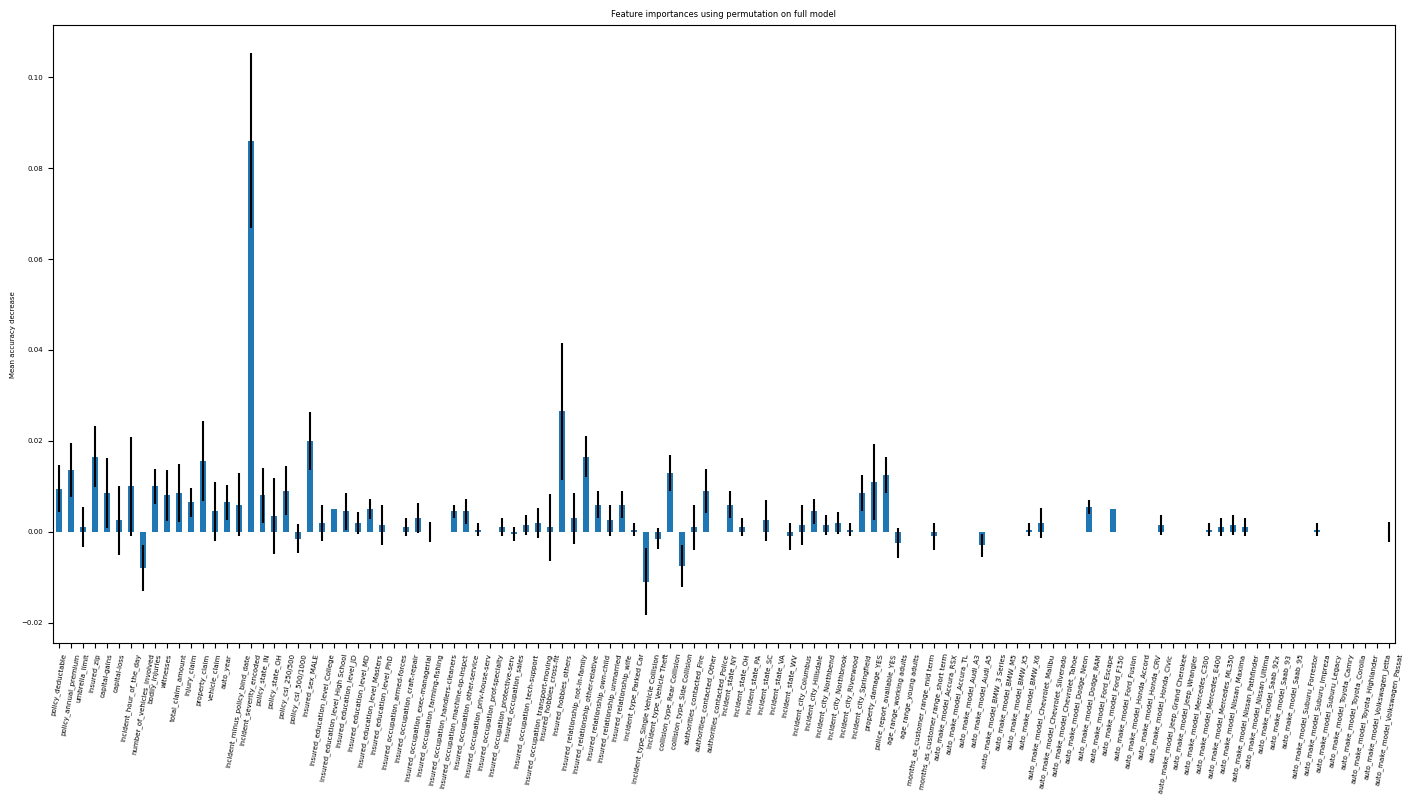

In [ ]:
feature_scores = pd.Series(forest_importances, index=X_train.columns).sort_values(ascending=False)

print(feature_scores)
plt.rcParams.update({'font.size': 5})

fig, ax = plt.subplots(figsize=(14, 8))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.xticks(rotation=80)
plt.show()

In [ ]:
# Remove features with low importance (e.g., < 0.0)
indices = np.argsort(forest_importances)[::-1]
important_features = [feature_names[i] for i in indices if importances[i] > 0.0]
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]


# Re-train the Random Forest using only selected features
pipeline.fit(X_train_filtered, y_train)

# Get probability scores (for AUC-ROC evaluation)
y_test_proba = pipeline.predict_proba(X_test_filtered)[:, 1]

y_test_pred = pipeline.predict(X_test_filtered)


In [ ]:
y_train_pred = pipeline.predict(X_train_filtered)

rand_clf_train_acc = accuracy_score(y_train,y_train_pred)
rand_clf_test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training accuracy of Random Forest is : {rand_clf_train_acc}")
print(f"Test accuracy of Random Forest is : {rand_clf_test_acc}")

auc_roc = roc_auc_score(y_test, y_test_proba)
print("Test AUC-ROC Score:", auc_roc)

print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Training accuracy of Random Forest is : 1.0
Test accuracy of Random Forest is : 0.815
Test AUC-ROC Score: 0.8287606433301797
[[138  13]
 [ 24  25]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       151
           1       0.66      0.51      0.57        49

    accuracy                           0.81       200
   macro avg       0.75      0.71      0.73       200
weighted avg       0.80      0.81      0.81       200



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_search = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': ['balanced', None]
}

random_search = RandomizedSearchCV(rf_model, param_search, n_iter=50, cv=5, scoring='f1', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': None, 'classifier__class_weight': None, 'classifier__bootstrap': True}


In [ ]:
best_forest = random_search.best_estimator_
best_forest.fit(X_train_filtered, y_train)

y_test_pred = best_forest.predict(X_test_filtered)
y_test_proba = best_forest.predict_proba(X_test_filtered)[:, 1]

y_train_pred = best_forest.predict(X_train_filtered)

rand_clf_train_acc = accuracy_score(y_train,y_train_pred)
rand_clf_test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training accuracy of Random Forest is : {rand_clf_train_acc}")
print(f"Test accuracy of Random Forest is : {rand_clf_test_acc}")

auc_roc = roc_auc_score(y_test, y_test_proba)
print("Test AUC-ROC Score:", auc_roc)

print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Training accuracy of Random Forest is : 0.97875
Test accuracy of Random Forest is : 0.77
Test AUC-ROC Score: 0.8286254899310718
[[137  14]
 [ 32  17]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       151
           1       0.55      0.35      0.42        49

    accuracy                           0.77       200
   macro avg       0.68      0.63      0.64       200
weighted avg       0.75      0.77      0.75       200



In [ ]:
# Define scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'true_negatives': make_scorer(tn),
    'false_positives': make_scorer(fp),
    'false_negatives': make_scorer(fn),
    'true_positives': make_scorer(tp)
}

# Cross-validation scores (no predictions here)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(best_forest, X_train_filtered, y_train, cv=5, scoring=scoring, return_train_score=True)

print(f"\n=== {cv} Averages ===")
for metric in ['train_accuracy', 'test_accuracy', 'test_precision', 'test_recall',
                'test_f1', 'test_roc_auc', 'test_true_negatives', 'test_false_positives',
                'test_false_negatives', 'test_true_positives']:
    avg = np.mean(cv_results[metric])
    print(f"{metric}: {avg:.4f}")


=== StratifiedKFold(n_splits=5, random_state=42, shuffle=True) Averages ===
train_accuracy: 0.9800
test_accuracy: 0.7913
test_precision: 0.6233
test_recall: 0.3838
test_f1: 0.4716
test_roc_auc: 0.6545
test_true_negatives: 111.4000
test_false_positives: 9.0000
test_false_negatives: 24.4000
test_true_positives: 15.2000


# Challenger Model 2
TabPFN (Tabular Prior-data Fitted Networks)
*   Source: https://arxiv.org/abs/2207.01848
*   Transformer-based model designed specifically for tabular data with speed
*   Provides some interpretability to explain fraud prediction, but less transparent compared to traditional methods like XGBoost and RandomForest
*   Larger model performs slower and need more computational resources than the other 2 methods
*   Might perform better on larger dataset compared to decision tree based methods








In [ ]:
from tabpfn import TabPFNClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, make_scorer, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import shapiq
import shapiq.plot as splot

def has_gpu():
    return torch.cuda.is_available()

In [9]:
boolean_cols = df.select_dtypes(include=[bool]).columns
df[boolean_cols] = df[boolean_cols].astype(int)
X = df.drop(columns=['fraud_reported'])
y = df['fraud_reported'].map({"Y":1,"N":0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
tabpfn_model = TabPFNClassifier(device="cuda" if has_gpu() else "cpu")
tabpfn_model.fit(X_train, y_train)

c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\tabpfn\classifier.py:431: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(self.device, X)


TabPFNClassifier(device='cpu')

In [ ]:
y_train_pred = tabpfn_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
y_test_pred = tabpfn_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)

print(f"Training accuracy of TabPFN is : {train_accuracy:.4f}")
print(f"Test accuracy of TabPFN is : {test_accuracy:.4f}")
print(f"Test AUC-ROC score: {roc_auc:.4f}")
print(cm)
print(classification_report(y_test, y_test_pred))

Training accuracy of TabPFN is : 0.8562
Test accuracy of TabPFN is : 0.8450
Test AUC-ROC score: 0.8491012298959318
[[127  24]
 [  7  42]]
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       151
           1       0.64      0.86      0.73        49

    accuracy                           0.84       200
   macro avg       0.79      0.85      0.81       200
weighted avg       0.87      0.84      0.85       200



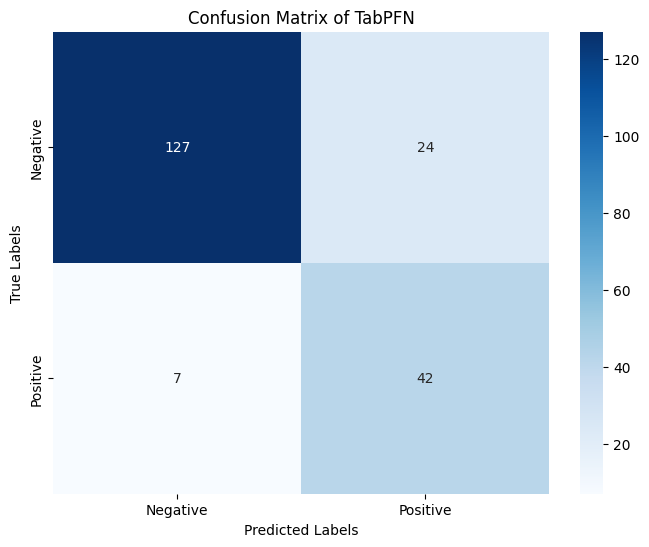

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of TabPFN')
plt.show()

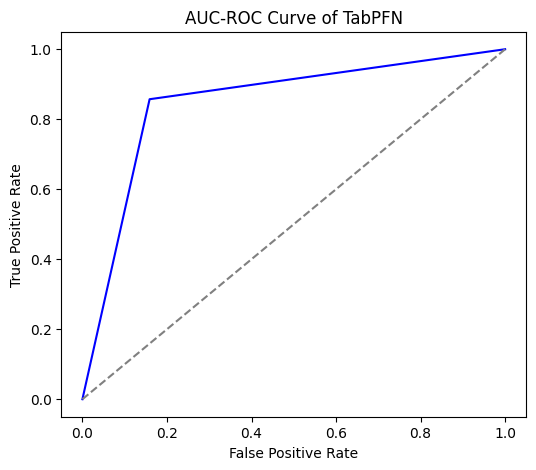

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve of TabPFN')
plt.show()

5-fold cross-validation is used below to obtain a more stable and reliable estimate of tabpfn model performance.
GPU is recommended.

In [ ]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

In [ ]:
# Define scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'true_negatives': make_scorer(tn),
    'false_positives': make_scorer(fp),
    'false_negatives': make_scorer(fn),
    'true_positives': make_scorer(tp)
}

# Cross-validation scores
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(tabpfn_model, X, y, cv=cv, scoring=scoring, return_train_score=True)

print(f"\n=== TabPFN {cv} Averages ===")
for metric in ['train_accuracy', 'test_accuracy', 'test_precision', 'test_recall',
                'test_f1', 'test_roc_auc', 'test_true_negatives', 'test_false_positives',
                'test_false_negatives', 'test_true_positives']:
    avg = np.mean(cv_results[metric])
    print(f"{metric}: {avg:.4f}")


=== TabPFN StratifiedKFold(n_splits=5, random_state=42, shuffle=True) Averages ===
train_accuracy: 0.8540
test_accuracy: 0.8540
test_precision: 0.6537
test_recall: 0.8868
test_f1: 0.7505
test_roc_auc: 0.8651
test_true_negatives: 127.0000
test_false_positives: 23.6000
test_false_negatives: 5.6000
test_true_positives: 43.8000


SHAPley waterfall plot for local explainability.

In [ ]:
explainer = shapiq.Explainer(model=tabpfn_model, data=X_train.to_numpy(), labels=y_train.to_numpy(), index="SV", max_order=1)
interaction_values = explainer.explain(X_test.iloc[0:1].to_numpy(), budget=1000, random_state=42)
feature_names = X_train.columns.tolist()
feature_values = X_test.iloc[0].values

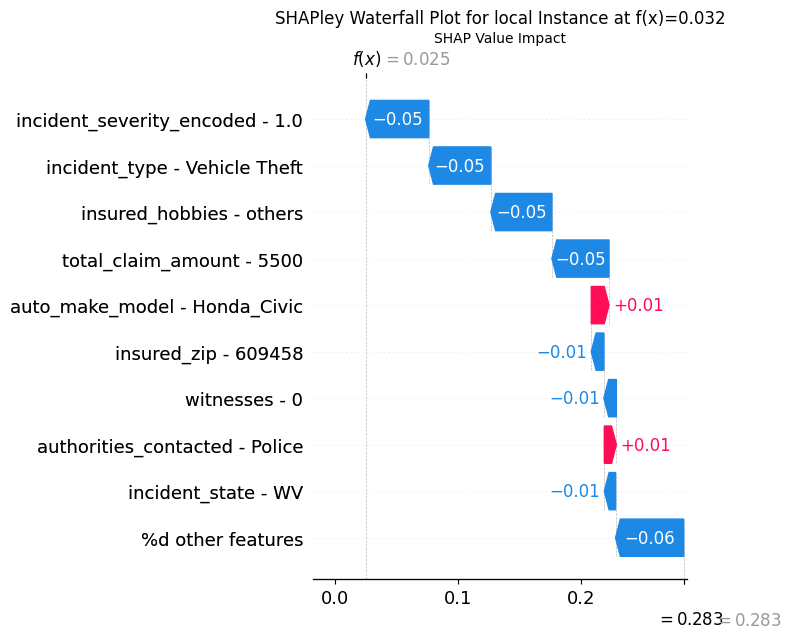

In [ ]:
# note that there is randomness is this plot which
ax = splot.waterfall_plot(interaction_values, feature_names=feature_names, show=False, abbreviate=False)
ax.set_title('SHAPley Waterfall Plot for local Instance at f(x)=0.032')
ax.set_xlabel('SHAP Value Impact')
ax.set_ylabel('Features')

y_labels = ax.get_yticklabels()
for label in y_labels:
    feature_label = label.get_text()
    if feature_label in feature_names:
        feature_idx = feature_names.index(feature_label)
        feature_val = feature_values[feature_idx]
        label.set_text(f"{feature_label} - {feature_val}")

ax.set_yticklabels(y_labels)

plt.tight_layout()
plt.show()

# Ensemble Model

In [22]:
import pandas as pd
import numpy as np

from itertools import combinations

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC

from xgboost import XGBClassifier

from scipy.spatial.distance import cdist, pdist

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = pd.read_csv(r"../data/processed/processed_data.csv")

tabPFN_model = tabpfn_model

## Ensemble of Models

### Data Preparation

In [13]:
target_col = "fraud_reported"

X = df.drop(columns=[target_col])
y = df[target_col].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### Over and Under Sampling

In [14]:
# for compatibility with TabPFN, we will be using the same inputs TabPFN uses
over = SMOTE(sampling_strategy=0.5, random_state=42)   # minority becomes 0.5 * majority (~800 * 0.75)
under = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # majority becomes equal to minority

resample_pipeline = Pipeline(steps=[
    ('o', over),
    ('u', under)
])

X_resampled, y_resampled = resample_pipeline.fit_resample(X_train, y_train)

print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_resampled))

Original class distribution: Counter({0: 602, 1: 198})
Resampled class distribution: Counter({0: 301, 1: 301})


### Training of Models

Models will be used for stacked ensemble method
1.   Random Forest
2.   Gradient Boosting
3.   XGBoost



In [15]:
### 1: Random Forest ###
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_params,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_resampled, y_resampled)
best_rf_resample = rf_search.best_estimator_
print(best_rf_resample)

y_pred = best_rf_resample.predict(X_test)
y_proba = best_rf_resample.predict_proba(X_test)[:, 1]
rand_clf_train_acc = accuracy_score(y_resampled,best_rf_resample.predict(X_resampled))
rand_clf_test_acc = accuracy_score(y_test, y_pred)
rand_clf_test_roc = roc_auc_score(y_test, y_proba)

print(f"Training accuracy of Random Forest is : {rand_clf_train_acc}")
print(f"Test accuracy of Random Forest is : {rand_clf_test_acc}")
print(f"ROC-AUC of Random Forest is : {rand_clf_test_roc:.4f}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

RandomForestClassifier(min_samples_leaf=2, min_samples_split=8, n_estimators=50,
                       random_state=42)
Training accuracy of Random Forest is : 0.9850498338870431
Test accuracy of Random Forest is : 0.775
ROC-AUC of Random Forest is : 0.7806
[[129  22]
 [ 23  26]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       151
           1       0.54      0.53      0.54        49

    accuracy                           0.78       200
   macro avg       0.70      0.69      0.69       200
weighted avg       0.77      0.78      0.77       200



In [16]:
### 2: Gradient Boosting ###

gb_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

gb_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=gb_params,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

gb_search.fit(X_resampled, y_resampled)
best_gb_resample = gb_search.best_estimator_
print(best_gb_resample)

y_pred = best_gb_resample.predict(X_test)
y_proba = best_gb_resample.predict_proba(X_test)[:, 1]
gb_train_acc = accuracy_score(y_resampled,best_gb_resample.predict(X_resampled))
gb_test_acc = accuracy_score(y_test, y_pred)
gb_roc_auc = roc_auc_score(y_test, y_proba)

print(f"Training accuracy of Grad Boosting is : {gb_train_acc}")
print(f"Test accuracy of Grad Boosting is : {gb_test_acc}")
print(f"ROC-AUC of Grad Boosting is : {gb_roc_auc:.4f}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

GradientBoostingClassifier(max_depth=7, n_estimators=150, random_state=42,
                           subsample=0.8)
Training accuracy of Grad Boosting is : 1.0
Test accuracy of Grad Boosting is : 0.82
ROC-AUC of Grad Boosting is : 0.8084
[[126  25]
 [ 11  38]]
              precision    recall  f1-score   support

           0       0.92      0.83      0.88       151
           1       0.60      0.78      0.68        49

    accuracy                           0.82       200
   macro avg       0.76      0.80      0.78       200
weighted avg       0.84      0.82      0.83       200



In [17]:
### 3: XGBoost ###

xgb_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',),
    param_distributions=xgb_params,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_resampled, y_resampled)
best_xgb_resample = xgb_search.best_estimator_
print(best_xgb_resample)

y_pred = best_xgb_resample.predict(X_test)
y_proba = best_xgb_resample.predict_proba(X_test)[:, 1]
xgb_train_acc = accuracy_score(y_resampled,best_xgb_resample.predict(X_resampled))
xgb_test_acc = accuracy_score(y_test, y_pred)
xgb_roc_auc = roc_auc_score(y_test, y_proba)

print(f"Training accuracy of XGBoost is : {xgb_train_acc}")
print(f"Test accuracy of XGBoost is : {xgb_test_acc}")
print(f"ROC-AUC of XGBoost is : {xgb_roc_auc:.4f}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)
Training accuracy of XGBoost is : 0.9219269102990033
Test accuracy of XGBoost is : 0.845
ROC-AUC of XGBoost is : 0.8334
[[130  21]
 [ 10  39]]
              precision    recall  f1-score   support

           0       0.93      0.86      0.89   

### Building out ensemble stack

In [23]:
# Possible models
other_models = [
    ('rf', best_rf_resample),
    ('gb', best_gb_resample),
    ('xgb', best_xgb_resample)
]

tabpfn = ('tabpfn', tabPFN_model)  # fixed model - our winning challenger

# Meta Learner with fixed hyperparams
meta_learner = SVC(kernel='linear', C=1, probability=True, random_state=42)
results = []

# Try all 2-model combinations with tabPFN fixed
for combo in combinations(other_models, 2):
    ensemble = list(combo) + [tabpfn]
    model_names = [name for name, _ in ensemble]
    print(f"Trying stack with: {model_names}")
    
    stacked = StackingClassifier(
        estimators=ensemble,
        final_estimator=meta_learner,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        stack_method='predict_proba',
        n_jobs=-1
    )

    y_pred_proba = cross_val_predict(stacked, X_resampled, y_resampled, cv=3, method='predict_proba', n_jobs=-1)
    y_pred = (y_pred_proba[:, 1] >= 0.5).astype(int)

    # metrics, use auc as final determinant but we log all just in case
    auc = roc_auc_score(y_resampled, y_pred_proba[:, 1])
    acc = accuracy_score(y_resampled, y_pred)
    fraud_precision = precision_score(y_resampled, y_pred, pos_label=1)
    fraud_recall = recall_score(y_resampled, y_pred, pos_label=1)

    results.append({
        "models": model_names,
        "roc_auc": round(auc, 4),
        "accuracy": round(acc, 4),
        "fraud_precision": round(fraud_precision, 4),
        "fraud_recall": round(fraud_recall, 4)
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='roc_auc', ascending=False).reset_index(drop=True)
print("Stacking Model Combination Results")
print(results_df.to_string(index=False))

# best combo
best_combo = results_df.iloc[0]["models"]
print(f"Best Model Combination: {best_combo}")


>>> Trying stack with: ['rf', 'gb', 'tabpfn']

>>> Trying stack with: ['rf', 'xgb', 'tabpfn']

>>> Trying stack with: ['gb', 'xgb', 'tabpfn']
Stacking Model Combination Results
           models  roc_auc  accuracy  fraud_precision  fraud_recall
[gb, xgb, tabpfn]   0.8692    0.8538           0.8447        0.8671
 [rf, gb, tabpfn]   0.8679    0.8522           0.8464        0.8605
[rf, xgb, tabpfn]   0.8673    0.8555           0.8452        0.8704
Best Model Combination: ['gb', 'xgb', 'tabpfn']


In [ ]:
# running and evaluation
# best_combo = ['gb', 'xgb', 'tabpfn']
model_dict = dict(other_models)
selected_ensemble = [(name, model_dict[name]) for name in best_combo if name != 'tabpfn']
selected_ensemble.append(tabpfn)

stacked_clf = StackingClassifier(
    estimators=selected_ensemble,
    final_estimator=meta_learner,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    stack_method='predict_proba',
    n_jobs=-1
)

# fit on data
stacked_clf.fit(X_test, y_test)
y_pred_final = stacked_clf.predict(X_test)
y_proba_final = stacked_clf.predict_proba(X_test)[:, 1]

# metrics
final_auc = roc_auc_score(y_test, y_proba_final)
final_acc = accuracy_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final, pos_label=1)
final_precision = precision_score(y_test, y_pred_final, pos_label=1)
final_recall = recall_score(y_test, y_pred_final, pos_label=1)
final_cm = confusion_matrix(y_test, y_pred_final)

# --- Final model evaluation ---
print("\n=== Final Stacked Model (on full resampled data) ===")
print(f"Accuracy       : {final_acc:.4f}")
print(f"F1 Score       : {final_f1:.4f}")
print(f"Fraud Precision: {final_precision:.4f}")
print(f"Fraud Recall   : {final_recall:.4f}")
print(f"ROC AUC        : {final_auc:.4f}")
print("\nConfusion Matrix:")
print(final_cm)


=== Final Stacked Model (on full resampled data) ===
Accuracy       : 0.8700
F1 Score       : 0.7547
Fraud Precision: 0.7018
Fraud Recall   : 0.8163
ROC AUC        : 0.8734

Confusion Matrix:
[[134  17]
 [  9  40]]


## Ensemble Model with Similarity Matching

### Preparation: Grabbing top_n features by incident state

In [25]:
df_corr = df.copy()
bool_cols = df_corr.select_dtypes(include='bool').columns
df_corr[bool_cols] = df_corr[bool_cols].astype(int)

target_col = "fraud_reported"
incident_state_cols = [col for col in df_corr.columns if col.startswith("incident_state_")]
feature_cols = [col for col in df_corr.columns if col != target_col and col not in incident_state_cols]

top_features_per_state = {}
top_n = 10  # toggleable/ refinable

for state_col in incident_state_cols:
    subset = df_corr[df_corr[state_col] == 1]

    if len(subset) < 20: #adjustable, for now all data points are kept (min is 23)
        continue  # skip small groups

    corr = subset[feature_cols + [target_col]].corr(numeric_only=True)

    # Defensive check
    if target_col not in corr.columns:
        continue

    top_corr = corr[target_col].drop(target_col).abs().sort_values(ascending=False).head(top_n)
    top_features_per_state[state_col] = top_corr.index.tolist()

# Preview results
for state, features in top_features_per_state.items():
    print(f"{state}: {features}")


incident_state_NY: ['insured_hobbies_others', 'insured_hobbies_cross-fit', 'vehicle_claim', 'total_claim_amount', 'auto_make_model_BMW_X6', 'insured_occupation_exec-managerial', 'incident_type_Parked Car', 'incident_severity_encoded', 'property_claim', 'insured_occupation_priv-house-serv']
incident_state_OH: ['months_as_customer_range_mid term', 'bodily_injuries', 'injury_claim', 'insured_relationship_other-relative', 'age_range_older adults', 'policy_state_OH', 'insured_occupation_tech-support', 'insured_occupation_farming-fishing', 'auto_make_model_Ford_F150', 'auto_make_model_Chevrolet_Tahoe']
incident_state_PA: ['insured_hobbies_others', 'insured_education_level_JD', 'policy_annual_premium', 'insured_hobbies_cross-fit', 'insured_education_level_PhD', 'insured_occupation_farming-fishing', 'auto_make_model_Audi_A5', 'auto_make_model_Saab_92x', 'auto_make_model_Dodge_RAM', 'insured_occupation_machine-op-inspct']
incident_state_SC: ['insured_hobbies_others', 'vehicle_claim', 'total_cla

### Visualisation of logic

1. If the distribution of fraud vs non-fraud by state is significantly different, that state's insurance reports can be considered for similarity matching
2. We look at distribution of distances from a fraud datapoint to non fraud/ fraud by the top 10 features
3. If the 5th percentils distributions are different enough (can be refined further), we can use it as a proxy for predicting fraud (by matching to a fraudulent/ non-fraudulent pattern)

c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


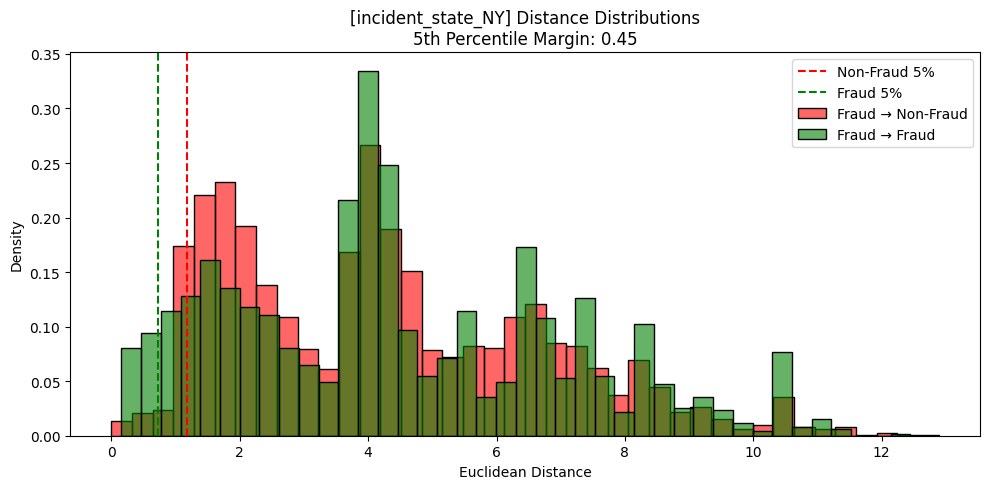

c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


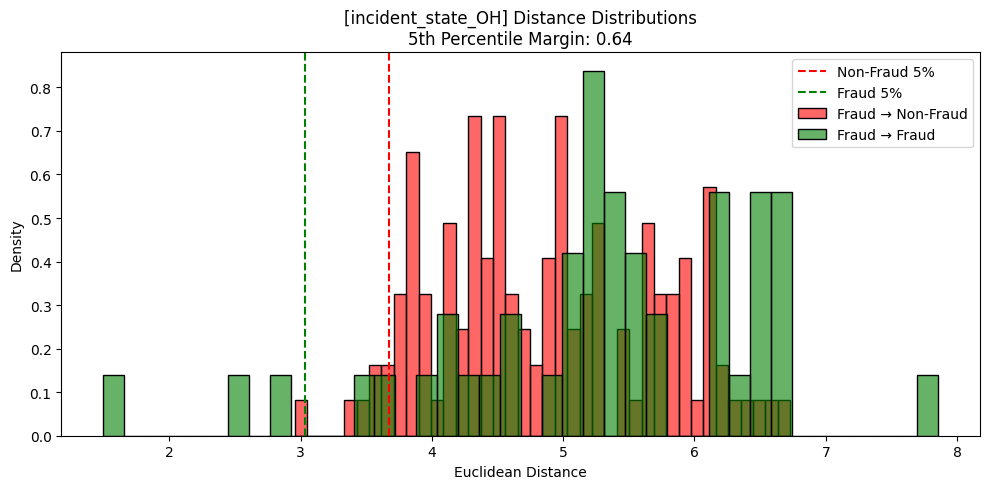

c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


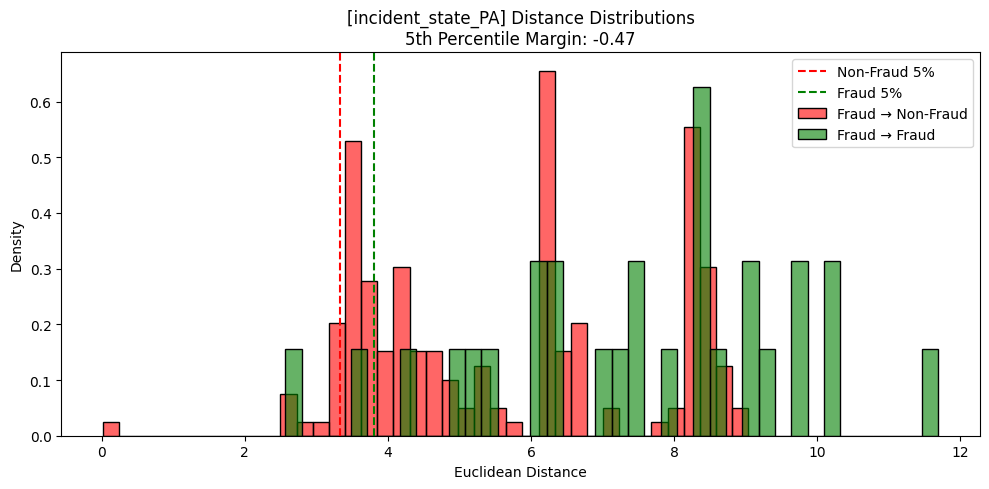

c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


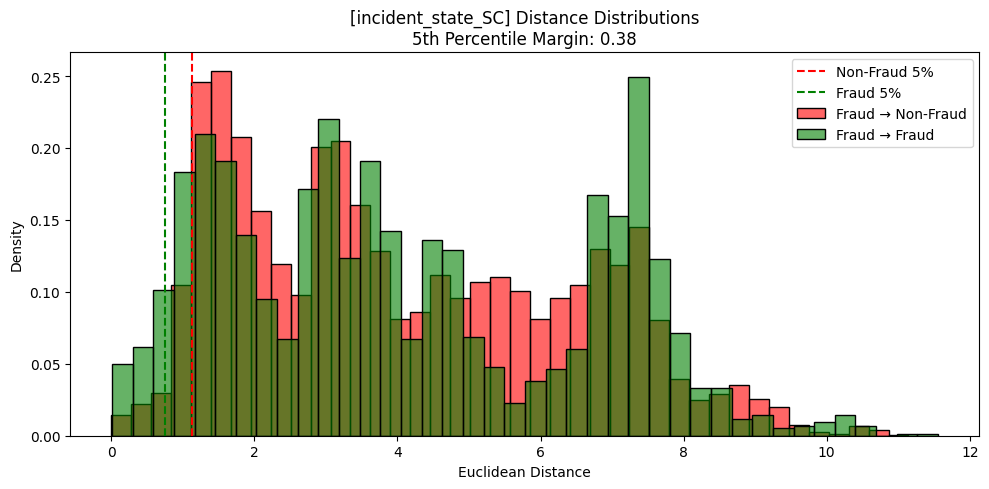

c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


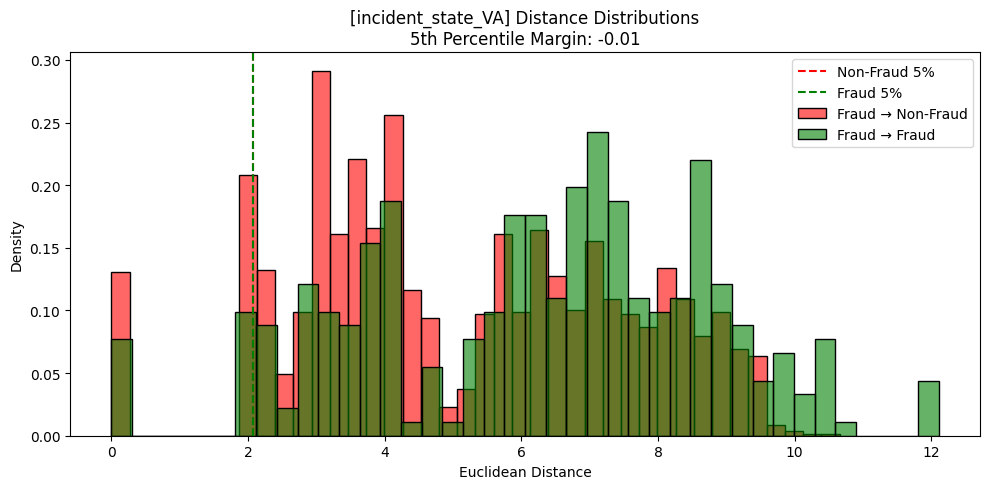

c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


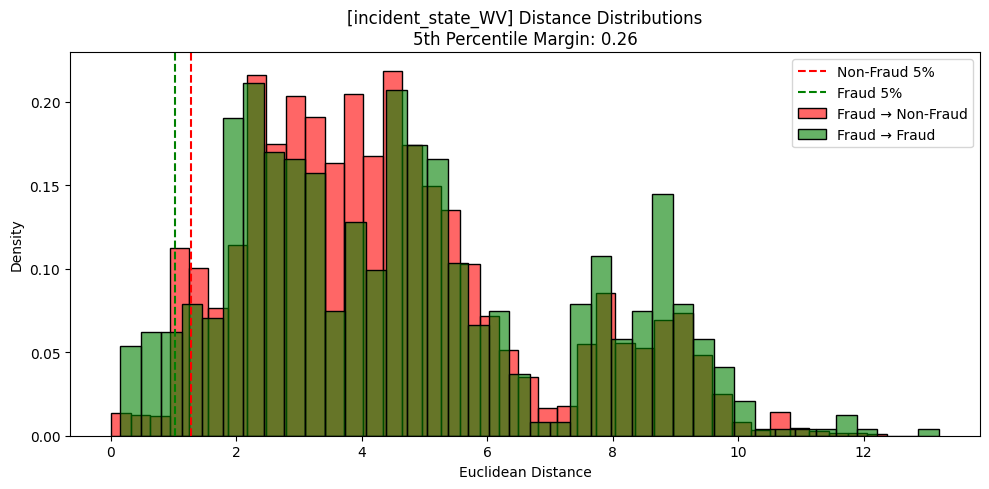

In [26]:
distance_thresholds = {}

for state, top_features in top_features_per_state.items():
    subset = df_corr[df_corr[state] == 1]

    if len(subset) < 20: # same as above, can adjust to be stricter
        print(f"Skipping {state} due to low sample size")
        continue

    X = subset[top_features]
    y = subset['fraud_reported']

    # scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # separarte non fraud and fraud
    X_fraud = X_scaled[y == 1]
    X_nonfraud = X_scaled[y == 0]

    if len(X_fraud) < 5 or len(X_nonfraud) < 5: # we assume we use n_neighbors = 5, hence if < 5 just ignore the state
        print(f"Skipping {state} due to insufficient fraud/non-fraud")
        continue

    # distance computation
    fraud_to_nonfraud = cdist(X_fraud, X_nonfraud, metric='euclidean').flatten()
    fraud_to_fraud = pdist(X_fraud, metric='euclidean')

    # 5th percentiles
    p5_f2nf = np.percentile(fraud_to_nonfraud, 5)
    p5_f2f = np.percentile(fraud_to_fraud, 5)
    margin = p5_f2nf - p5_f2f

    distance_thresholds[state] = {
        'fraud_to_nonfraud_5pct': p5_f2nf,
        'fraud_to_fraud_5pct': p5_f2f,
        '5pct_margin': margin
    }

    # Plot
    plt.figure(figsize=(10, 5))
    sns.histplot(fraud_to_nonfraud, bins=40, color='red', label='Fraud → Non-Fraud', stat='density', alpha=0.6)
    sns.histplot(fraud_to_fraud, bins=40, color='green', label='Fraud → Fraud', stat='density', alpha=0.6)

    plt.axvline(p5_f2nf, color='red', linestyle='--', label='Non-Fraud 5%')
    plt.axvline(p5_f2f, color='green', linestyle='--', label='Fraud 5%')

    plt.title(f"[{state}] Distance Distributions\n5th Percentile Margin: {margin:.2f}")
    plt.xlabel("Euclidean Distance")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Preparation for pipeline

In [37]:
def predict_with_similarity_or_ensemble(input_vector, input_dict, ensemble_model, default_prob=None):
    active_state = next((k for k, v in input_dict.items() if k.startswith("incident_state_") and v == 1), None)

    if active_state not in state_models:
        # Fallback to ensemble model
        return 0, 0, 0

    model = state_models[active_state]
    top_feats = model["features"]
    threshold = model["threshold"]

    # Extract only the relevant top features for this state
    input_feats = np.array([input_dict[feat] for feat in top_feats]).reshape(1, -1)
    input_scaled = model["scaler"].transform(input_feats)

    # Get distance to nearest 5 fraud cases
    distances, indices = model["knn"].kneighbors(input_scaled, n_neighbors=5)
    neighbor_labels = model["labels"][indices[0]]  # grab their original labels
    fraud_ratio = np.mean(neighbor_labels)

    if distances[0][4] < threshold and fraud_ratio >  0.4:
        majority_vote = Counter(neighbor_labels).most_common(1)[0][0]
        return majority_vote, 1, fraud_ratio
    elif distances[0][4] < threshold and fraud_ratio <=  0.4:
        majority_vote = Counter(neighbor_labels).most_common(1)[0][0]
        return majority_vote, 1, fraud_ratio
    else:
        return 0, 0, 0


In [28]:
state_models = {}

for state, top_features in top_features_per_state.items():
    margin = distance_thresholds[state]['5pct_margin']
    if abs(margin) <= 0.35:
        continue

    subset = df_corr[df_corr[state] == 1]
    X = subset[top_features]
    y = subset['fraud_reported']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    knn = NearestNeighbors(n_neighbors=5)
    knn.fit(X_scaled)  # 🔁 Use all samples (not just fraud)

    state_models[state] = {
        "features": top_features,
        "scaler": scaler,
        "knn": knn,
        "threshold": (
            distance_thresholds[state]['fraud_to_nonfraud_5pct'] +
            distance_thresholds[state]['fraud_to_fraud_5pct']
        ) / 2,
        "labels": y.values  # 🔁 Use all labels
    }


In [29]:
df_raw = df.copy()  # assuming this includes the full, unscaled, unprocessed DataFrame
X_raw = df_raw.drop(columns=['fraud_reported'])

X_raw_train, X_raw_test = train_test_split(
    X_raw, test_size=0.2, random_state=42, stratify=df['fraud_reported']
)

### Running and evaluating model

In [39]:
from tqdm import tqdm  # install with `pip install tqdm` if not already installed
import warnings
from collections import Counter

final_preds = []
final_probs = []
used_similarity_flags = []

sim_preds, sim_true, sim_proba = [], [], []
ens_preds, ens_true = [], []

print("Running Hybrid Inference...\n")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for i in tqdm(range(len(X_test)), desc="Processing"):
        input_vector = X_test[i]
        input_dict = X_raw_test.iloc[i].to_dict()
        true_label = y_test[i]

        # Shortcut check
        active_state = next((k for k, v in input_dict.items() if k.startswith("incident_state_") and v == 1), None)
        use_similarity = active_state in state_models

        if use_similarity:
            pred, used_similarity, sim_prob = predict_with_similarity_or_ensemble(
                input_vector=input_vector,
                input_dict=input_dict,
                ensemble_model=stacked_clf
            )
        else:
            pred = y_pred_final[i]
            sim_prob = y_proba_final[i]
            used_similarity = 0

        if used_similarity == 0:
            pred = y_pred_final[i]
            sim_prob = y_proba_final[i]
            used_similarity = 0

        # Store results
        final_preds.append(pred)
        final_probs.append(sim_prob)
        used_similarity_flags.append(used_similarity)

        if used_similarity:
            sim_preds.append(pred)
            sim_true.append(true_label)
            sim_proba.append(sim_prob)
        else:
            ens_preds.append(pred)
            ens_true.append(true_label)

# --- Evaluation ---
print("-- Overall Evaluation (Hybrid System) --")
print(f"Similarity-based predictions used: {sum(used_similarity_flags)} / {len(X_test)}")
print(f"Accuracy       : {accuracy_score(y_test, final_preds):.4f}")
print(f"F1 Score       : {f1_score(y_test, final_preds):.4f}")
print(f"ROC-AUC        : {roc_auc_score(y_test, final_probs):.4f}")
print(f"Fraud Precision: {precision_score(y_test, final_preds, pos_label=1):.4f}")
print(f"Fraud Recall   : {recall_score(y_test, final_preds, pos_label=1):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, final_preds))

if sim_preds:
    print("\n--- Similarity-Based Predictions Only ---")
    print(f"Count          : {len(sim_preds)}")
    print(f"Accuracy       : {accuracy_score(sim_true, sim_preds):.4f}")
    print(f"F1 Score       : {f1_score(sim_true, sim_preds):.4f}")
    print(f"ROC-AUC        : {roc_auc_score(sim_true, sim_proba):.4f}")
    print(f"Fraud Precision: {precision_score(sim_true, sim_preds, pos_label=1):.4f}")
    print(f"Fraud Recall   : {recall_score(sim_true, sim_preds, pos_label=1):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(sim_true, sim_preds))
else:
    print("\nNo similarity-based predictions were used.")


Running Hybrid Inference...



Processing: 100%|██████████| 200/200 [00:00<00:00, 2335.71it/s]

-- Overall Evaluation (Hybrid System) --
Similarity-based predictions used: 91 / 200
Accuracy       : 0.8650
F1 Score       : 0.7327
ROC-AUC        : 0.9094
Fraud Precision: 0.7115
Fraud Recall   : 0.7551
Confusion Matrix:
[[136  15]
 [ 12  37]]

--- Similarity-Based Predictions Only ---
Count          : 91
Accuracy       : 0.9121
F1 Score       : 0.7333
ROC-AUC        : 0.9658
Fraud Precision: 0.8462
Fraud Recall   : 0.6471
Confusion Matrix:
[[72  2]
 [ 6 11]]
